In [2]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Unzip your dataset (adjust the path if your zip is elsewhere)
!unzip -q "/content/drive/MyDrive/GERALD_subset.zip" -d "/content/"

print("Done! Dataset extracted to /content/GERALD_subset")


Mounted at /content/drive
Done! Dataset extracted to /content/GERALD_subset


In [3]:
from pathlib import Path
import xml.etree.ElementTree as ET
import cv2

# ROOT DIRECTORIES
root_dataset_dir = Path("/content/GERALD_subset/")
images_directory = root_dataset_dir / "images"
annotations_directory = root_dataset_dir / "annotations"

# DIAGNOSTIC COUNTERS
xml_file_count = 0
label_file_count = 0
total_detected_objects = 0
skipped_file_list = []
sample_label_outputs = []

print(f"Root directory: {root_dataset_dir}")
print(f"Images directory: {images_directory} (exists: {images_directory.exists()})")
print(f"Annotations directory: {annotations_directory} (exists: {annotations_directory.exists()})")
print(f"XML files found: {len(list(annotations_directory.glob('*.xml')))}")
print(f"Image files found: {len(list(images_directory.glob('*.jpg')))}")
print("=" * 60)

# PROCESS EACH XML FILE
for xml_annotation_file in annotations_directory.glob("*.xml"):
    xml_file_count += 1

    try:
        # LOAD XML
        try:
            xml_tree = ET.parse(xml_annotation_file)
            xml_root = xml_tree.getroot()
        except Exception as parse_err:
            print(f"Failed to parse XML: {xml_annotation_file.name} ({parse_err})")
            skipped_file_list.append(xml_annotation_file.name)
            continue

        # EXTRACT IMAGE NAME
        image_filename = xml_root.find("filename").text
        image_path = images_directory / image_filename

        # VERIFY IMAGE EXISTS
        if not image_path.exists():
            print(f"Image not found: {image_filename}")
            skipped_file_list.append(image_filename)
            continue

        # LOAD IMAGE
        try:
            image = cv2.imread(str(image_path))
        except Exception as read_err:
            print(f"Error reading image {image_filename}: {read_err}")
            skipped_file_list.append(image_filename)
            continue

        if image is None:
            print(f"cv2 failed to load image: {image_filename}")
            skipped_file_list.append(image_filename)
            continue

        image_height, image_width = image.shape[:2]

        yolo_lines = []
        object_count = 0

        # PROCESS EACH OBJECT
        for detected_object in xml_root.findall("object"):

            class_name = detected_object.find("name").text.strip()
            class_id = 0 if class_name == "main_signal" else 1

            bounding_box = detected_object.find("bndbox")

            # RAW COORDINATES
            x_min = float(bounding_box.find("xmin").text)
            y_min = float(bounding_box.find("ymin").text)
            x_max = float(bounding_box.find("xmax").text)
            y_max = float(bounding_box.find("ymax").text)

            # YOLO NORMALIZATION
            center_x = ((x_min + x_max) / 2) / image_width
            center_y = ((y_min + y_max) / 2) / image_height
            box_width = (x_max - x_min) / image_width
            box_height = (y_max - y_min) / image_height

            # VALIDATION CHECK
            if not (0 <= center_x <= 1 and 0 <= center_y <= 1 and
                    0 <= box_width <= 1 and 0 <= box_height <= 1):
                print(f"Invalid coordinates in {image_filename}: "
                      f"cx={center_x}, cy={center_y}, w={box_width}, h={box_height}")

            yolo_lines.append(
                f"{class_id} {center_x:.6f} {center_y:.6f} {box_width:.6f} {box_height:.6f}"
            )

            object_count += 1
            total_detected_objects += 1

        # SAVE YOLO LABEL FILE
        label_output_file = images_directory / (xml_annotation_file.stem + ".txt")
        try:
            with open(label_output_file, "w") as label_file:
                label_file.write("\n".join(yolo_lines))
        except Exception as write_err:
            print(f"Failed to write label file {label_output_file.name}: {write_err}")
            skipped_file_list.append(xml_annotation_file.name)
            continue

        label_file_count += 1

        # SAVE SAMPLE OUTPUTS FOR INSPECTION
        if len(sample_label_outputs) < 3:
            sample_label_outputs.append({
                'xml_file': xml_annotation_file.name,
                'image_file': image_filename,
                'label_file': label_output_file.name,
                'objects_detected': object_count,
                'image_size': f"{image_width}x{image_height}",
                'sample_label': yolo_lines[0] if yolo_lines else "EMPTY"
            })

    except Exception as general_err:
        print(f"Error processing {xml_annotation_file.name}: {general_err}")
        skipped_file_list.append(xml_annotation_file.name)

# ---------------- SUMMARY OUTPUT ---------------- #

print("\n" + "=" * 60)
print("SUMMARY:")
print(f"XML files processed: {xml_file_count}")
print(f"Label files created: {label_file_count}")
print(f"Total objects annotated: {total_detected_objects}")
print(f"Skipped files: {len(skipped_file_list)}")
print(f"Average objects per image: "
      f"{total_detected_objects / label_file_count if label_file_count else 0:.2f}")

print("\n SAMPLE OUTPUTS:")
for i, sample in enumerate(sample_label_outputs, 1):
    print(f"\nSample {i}:")
    print(f"XML: {sample['xml_file']}")
    print(f"Image: {sample['image_file']} ({sample['image_size']})")
    print(f"Label File: {sample['label_file']}")
    print(f"Objects: {sample['objects_detected']}")
    print(f"Example YOLO Line: {sample['sample_label']}")

if skipped_file_list:
    print(f"\nSKIPPED {len(skipped_file_list)} FILES:")
    for f in skipped_file_list[:5]:
        print(f"   - {f}")
    if len(skipped_file_list) > 5:
        print(f"... and {len(skipped_file_list) - 5} more")

# VERIFICATION OF LABEL FILES
print("\nVERIFICATION:")
label_files_list = list(images_directory.glob("*.txt"))
print(f".txt files in images folder: {len(label_files_list)}")
if label_files_list:
    print(f"First 3 label files: {[f.name for f in label_files_list[:3]]}")


Root directory: /content/GERALD_subset
Images directory: /content/GERALD_subset/images (exists: True)
Annotations directory: /content/GERALD_subset/annotations (exists: True)
XML files found: 1967
Image files found: 1967

SUMMARY:
XML files processed: 1967
Label files created: 1967
Total objects annotated: 3942
Skipped files: 0
Average objects per image: 2.00

 SAMPLE OUTPUTS:

Sample 1:
XML: Ingolstadt_Muenchen.mp4#t=4018.166667.xml
Image: Ingolstadt_Muenchen.mp4#t=4018.166667.jpg (1920x1080)
Label File: Ingolstadt_Muenchen.mp4#t=4018.166667.txt
Objects: 2
Example YOLO Line: 1 0.502083 0.484722 0.005208 0.010185

Sample 2:
XML: Werlau-K%C3%B6ln.mp4#t=4266.633333.xml
Image: Werlau-K%C3%B6ln.mp4#t=4266.633333.jpg (1920x1080)
Label File: Werlau-K%C3%B6ln.mp4#t=4266.633333.txt
Objects: 2
Example YOLO Line: 0 0.593229 0.102315 0.021875 0.080556

Sample 3:
XML: Rheydt-Aachen.mp4#t=4629.9.xml
Image: Rheydt-Aachen.mp4#t=4629.9.jpg (1920x1080)
Label File: Rheydt-Aachen.mp4#t=4629.9.txt
Objects

In [4]:
#Class Distribution Analysis

import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path

annotations_dir = Path("/content/GERALD_subset/annotations")
class_list = []

for xml_file in annotations_dir.glob("*.xml"):
    try:
        root = ET.parse(xml_file).getroot()
        for obj in root.findall("object"):
            class_list.append(obj.find("name").text.strip())
    except:
        pass

print("Class Distribution:")
print(Counter(class_list))


Class Distribution:
Counter({'main_signal': 2551, 'distant_signal': 1391})


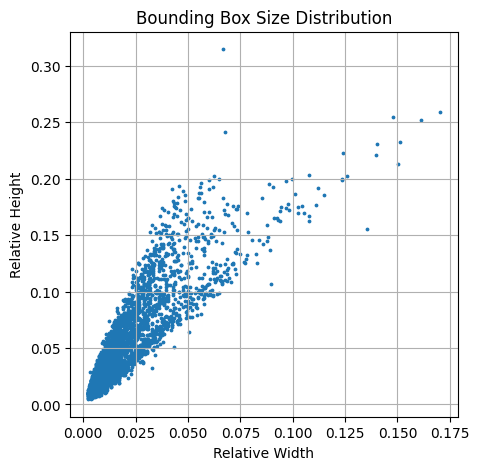

In [5]:
#Bounding Box Size Distribution

import matplotlib.pyplot as plt

box_widths = []
box_heights = []

for xml_file in annotations_dir.glob("*.xml"):
    try:
        root = ET.parse(xml_file).getroot()
        img_w = int(root.find("size/width").text)
        img_h = int(root.find("size/height").text)

        for obj in root.findall("object"):
            bb = obj.find("bndbox")
            xmin = float(bb.find("xmin").text)
            ymin = float(bb.find("ymin").text)
            xmax = float(bb.find("xmax").text)
            ymax = float(bb.find("ymax").text)

            box_widths.append((xmax - xmin) / img_w)
            box_heights.append((ymax - ymin) / img_h)
    except:
        pass

plt.figure(figsize=(5,5))
plt.scatter(box_widths, box_heights, s=3)
plt.xlabel("Relative Width")
plt.ylabel("Relative Height")
plt.title("Bounding Box Size Distribution")
plt.grid(True)
plt.show()


In [6]:
from pathlib import Path
import shutil
import xml.etree.ElementTree as ET
from collections import defaultdict
import random

# Reproducibility
random.seed(42)

# Directories (consistent with first script naming)
root_dataset_dir = Path("/content/GERALD_subset")
images_directory = root_dataset_dir / "images"
annotations_directory = root_dataset_dir / "annotations"

# Train/Val output directories
train_output_dir = root_dataset_dir / "train"
validation_output_dir = root_dataset_dir / "val"

(train_output_dir / "images").mkdir(parents=True, exist_ok=True)
(train_output_dir / "labels").mkdir(parents=True, exist_ok=True)
(validation_output_dir / "images").mkdir(parents=True, exist_ok=True)
(validation_output_dir / "labels").mkdir(parents=True, exist_ok=True)

print("Parsing metadata for stratified split!!!!!\n")

# Group images by weather–light condition
weather_light_groups = defaultdict(list)

for xml_annotation_file in annotations_directory.glob("*.xml"):
    try:
        xml_tree = ET.parse(xml_annotation_file)
        xml_root = xml_tree.getroot()

        # Extract metadata if available
        metadata_node = xml_root.find("metadata")
        if metadata_node is not None:
            try:
                weather = metadata_node.find("weather").text
                light = metadata_node.find("light").text
                condition_key = f"{weather}_{light}"
            except Exception:
                condition_key = "Unknown_Unknown"
        else:
            condition_key = "Unknown_Unknown"

        image_filename = xml_root.find("filename").text
        weather_light_groups[condition_key].append(image_filename)

    except Exception as parse_error:
        print(f"Skipping {xml_annotation_file.name} due to error: {parse_error}")

# Display condition groups
print(f"Found {len(weather_light_groups)} weather-light combinations:\n")
for condition_key, image_list in sorted(weather_light_groups.items()):
    print(f"  {condition_key}: {len(image_list)} images")

# Perform stratified 80/20 train-val split
train_image_list = []
validation_image_list = []

for condition_key, grouped_images in weather_light_groups.items():
    random.shuffle(grouped_images)
    train_cutoff = int(len(grouped_images) * 0.8)

    train_image_list.extend(grouped_images[:train_cutoff])
    validation_image_list.extend(grouped_images[train_cutoff:])

total_images = len(list(images_directory.glob('*.jpg')))

print("\nSplit Summary:")
print(f"Training: {len(train_image_list)} images "
      f"({len(train_image_list) / total_images * 100:.1f}%)")
print(f"Validation: {len(validation_image_list)} images "
      f"({len(validation_image_list) / total_images * 100:.1f}%)")

# Copy files to train/val directories
print("\nCopying files...\n")

def copy_image_and_label(image_filename, source_dir, target_dir):
    try:
        source_image_path = source_dir / image_filename
        source_label_path = source_dir / (Path(image_filename).stem + ".txt")

        if source_image_path.exists():
            shutil.copy(source_image_path, target_dir / "images" / image_filename)

        if source_label_path.exists():
            shutil.copy(source_label_path, target_dir / "labels" / source_label_path.name)

    except Exception as copy_error:
        print(f"Failed copying {image_filename}: {copy_error}")

# Copy training files
for img_file in train_image_list:
    copy_image_and_label(img_file, images_directory, train_output_dir)

# Copy validation files
for img_file in validation_image_list:
    copy_image_and_label(img_file, images_directory, validation_output_dir)

# Final report
print("\nTrain/Validation split complete!")
print(f"  Train images: {len(list((train_output_dir / 'images').glob('*')))}")
print(f"  Train labels: {len(list((train_output_dir / 'labels').glob('*')))}")
print(f"  Val images: {len(list((validation_output_dir / 'images').glob('*')))}")
print(f"  Val labels: {len(list((validation_output_dir / 'labels').glob('*')))}")

# Verify stratification consistency
print("\nVerifying stratification in validation set:\n")
validation_condition_counts = defaultdict(int)

for xml_annotation_file in annotations_directory.glob("*.xml"):
    try:
        xml_tree = ET.parse(xml_annotation_file)
        xml_root = xml_tree.getroot()
        image_filename = xml_root.find("filename").text

        if image_filename in validation_image_list:
            metadata_node = xml_root.find("metadata")
            if metadata_node is not None:
                try:
                    weather = metadata_node.find("weather").text
                    light = metadata_node.find("light").text
                    validation_condition_counts[f"{weather}_{light}"] += 1
                except Exception:
                    validation_condition_counts["Unknown_Unknown"] += 1

    except Exception as e:
        print(f"Error validating {xml_annotation_file.name}: {e}")

for condition_key, count in sorted(validation_condition_counts.items()):
    print(f"  {condition_key}: {count} images")


Parsing metadata for stratified split!!!!!

Found 13 weather-light combinations:

  Cloudy_Dark: 68 images
  Cloudy_Daylight: 244 images
  Cloudy_Twilight: 273 images
  Foggy_Daylight: 3 images
  Foggy_Twilight: 160 images
  Rainy_Daylight: 199 images
  Rainy_Twilight: 273 images
  Snowy_Daylight: 8 images
  Snowy_Twilight: 156 images
  Sunny_Daylight: 265 images
  Sunny_Twilight: 70 images
  Unknown_Dark: 242 images
  Unknown_Twilight: 6 images

Split Summary:
Training: 1569 images (79.8%)
Validation: 398 images (20.2%)

Copying files...


Train/Validation split complete!
  Train images: 1569
  Train labels: 1569
  Val images: 398
  Val labels: 398

Verifying stratification in validation set:

  Cloudy_Dark: 14 images
  Cloudy_Daylight: 49 images
  Cloudy_Twilight: 55 images
  Foggy_Daylight: 1 images
  Foggy_Twilight: 32 images
  Rainy_Daylight: 40 images
  Rainy_Twilight: 55 images
  Snowy_Daylight: 2 images
  Snowy_Twilight: 32 images
  Sunny_Daylight: 53 images
  Sunny_Twilight: 1

In [7]:
#Weather & Light Condition Frequency

from collections import Counter
weather_light_counter = Counter()

for xml_file in annotations_dir.glob("*.xml"):
    root = ET.parse(xml_file).getroot()
    meta = root.find("metadata")

    if meta is None:
        weather_light_counter["Unknown_Unknown"] += 1
        continue

    try:
        weather = meta.find("weather").text
        light = meta.find("light").text
        key = f"{weather}_{light}"
    except:
        key = "Unknown_Unknown"

    weather_light_counter[key] += 1

print("Weather-Light Condition Distribution:")
for k, v in weather_light_counter.items():
    print(f"{k}: {v} images")


Weather-Light Condition Distribution:
Rainy_Daylight: 199 images
Sunny_Daylight: 265 images
Unknown_Dark: 242 images
Foggy_Twilight: 160 images
Rainy_Twilight: 273 images
Cloudy_Twilight: 273 images
Snowy_Twilight: 156 images
Sunny_Twilight: 70 images
Cloudy_Daylight: 244 images
Cloudy_Dark: 68 images
Snowy_Daylight: 8 images
Unknown_Twilight: 6 images
Foggy_Daylight: 3 images


In [8]:
from pathlib import Path
import yaml

root_dataset_dir = Path("/content/GERALD_subset")
train_images_path = root_dataset_dir / "train" / "images"
validation_images_path = root_dataset_dir / "val" / "images"

# Prepare YOLO YAML data structure
dataset_yaml_config = {
    'train': str(train_images_path),
    'val': str(validation_images_path),
    'nc': 2,
    'names': ['main_signal', 'distant_signal']
}

yaml_output_file = root_dataset_dir / "data.yaml"

# Write YAML safely
try:
    with open(yaml_output_file, 'w') as yaml_file:
        yaml.dump(dataset_yaml_config, yaml_file, default_flow_style=False)
    print(f"data.yaml created at {yaml_output_file}")

except Exception as write_error:
    print(f"Error writing YAML file: {write_error}")

# Display YAML contents
print("\nContents:")
try:
    with open(yaml_output_file, 'r') as read_yaml:
        print(read_yaml.read())
except Exception as read_error:
    print(f"Error reading YAML file: {read_error}")

# Verification of dataset structure
print("\nVerification:")
try:
    print(f"Train path exists: {train_images_path.exists()}")
    print(f"Val path exists: {validation_images_path.exists()}")
    print(f"Train images: {len(list(train_images_path.glob('*.jpg')))}")
    print(f"Val images: {len(list(validation_images_path.glob('*.jpg')))}")

except Exception as verification_error:
    print(f"Error verifying dataset paths: {verification_error}")


data.yaml created at /content/GERALD_subset/data.yaml

Contents:
names:
- main_signal
- distant_signal
nc: 2
train: /content/GERALD_subset/train/images
val: /content/GERALD_subset/val/images


Verification:
Train path exists: True
Val path exists: True
Train images: 1569
Val images: 398


In [9]:
# Check one specific file manually
sample_img = "Mainz-Darmstadt.mp4#t=1830.766667.jpg"
sample_txt = images_directory / "Mainz-Darmstadt.mp4#t=1830.766667.txt"

print(f"Image exists: {(images_directory / sample_img).exists()}")
print(f"Label exists: {sample_txt.exists()}")

if sample_txt.exists():
    print(f"\nLabel content:")
    print(sample_txt.read_text())
else:
    print("LABEL FILE NOT CREATED!")

Image exists: True
Label exists: True

Label content:
0 0.528125 0.208796 0.023958 0.080556
1 0.526302 0.296296 0.026562 0.062963
0 0.104167 0.158333 0.034375 0.100000


In [10]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.5 MB/s eta 0:00:00


In [11]:
from ultralytics import YOLO
import time

start_time = time.time()

model = YOLO("yolov8n.pt")

results = model.train(
    data="/content/GERALD_subset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=32,
    patience=15,

    # Speed optimizations:
    cache=True,
    workers=8,

    mosaic=0.0,
    mixup=0.0,
    degrees=0.0,
    scale=0.0,
    fliplr=0.0,
    flipud=0.0,
    hsv_h=0.0,
    hsv_s=0.0,
    hsv_v=0.0,
    translate=0.0,
    shear=0.0,

    name="signal_baseline_no_aug",
    save_period=20,
    plots=True,
    verbose=True,

    save_txt=True,
    save_conf=True
)

elapsed = (time.time() - start_time) / 60
print(f"\n Training completed in {elapsed:.1f} minutes")

print("\n Final Metrics:")
print(f"  Overall mAP@0.5: {results.results_dict['metrics/mAP50(B)']:.3f}")
print(f"  Overall mAP@0.5:0.95: {results.results_dict['metrics/mAP50-95(B)']:.3f}")
print(f"  Precision: {results.results_dict['metrics/precision(B)']:.3f}")
print(f"  Recall: {results.results_dict['metrics/recall(B)']:.3f}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/GERALD_subset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=

In [12]:
#Per-Weather Evaluation (Baseline Model)

from ultralytics import YOLO
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import defaultdict
import pandas as pd

print("Evaluating Baseline Model per Weather Condition...\n")

# Load baseline model
baseline_model = YOLO("/content/runs/detect/signal_baseline_no_aug/weights/best.pt")

# Paths
dataset_root = Path("/content/GERALD_subset")
ann_dir = dataset_root / "annotations"
val_dir = dataset_root / "val" / "images"

# Group validation images by weather
weather_image_groups = defaultdict(list)
val_image_set = set([img.name for img in val_dir.glob("*.jpg")])

for xml_file in ann_dir.glob("*.xml"):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        img_name = root.find("filename").text

        if img_name in val_image_set:
            metadata = root.find("metadata")
            if metadata is not None:
                weather = metadata.find("weather").text
                weather_image_groups[weather].append(img_name)
    except:
        continue

print("Validation Set Weather Distribution:")
for weather, imgs in sorted(weather_image_groups.items()):
    print(f"  {weather}: {len(imgs)} images")

# Evaluate each weather condition separately
print("\nRunning inference per weather condition\n")

baseline_weather_results = {}

for weather, img_list in weather_image_groups.items():
    if len(img_list) < 5:
        print(f"Skipping {weather}: only {len(img_list)} samples")
        continue

    print(f"  Evaluating {weather} ({len(img_list)} images)...", end=" ")

    # Create temporary file list for this weather
    temp_val_list = val_dir.parent / f"temp_{weather}_list.txt"
    with open(temp_val_list, 'w') as f:
        for img in img_list:
            f.write(str(val_dir / img) + '\n')

    # Run inference on this weather subset
    results_list = []
    for img_name in img_list:
        img_path = val_dir / img_name
        if img_path.exists():
            result = baseline_model.predict(
                source=str(img_path),
                save=False,
                verbose=False,
                conf=0.25
            )
            results_list.append(result[0])

    total_detections = sum([len(r.boxes) for r in results_list])
    avg_confidence = sum([r.boxes.conf.mean().item() if len(r.boxes) > 0 else 0
                          for r in results_list]) / len(results_list)

    baseline_weather_results[weather] = {
        'images': len(img_list),
        'total_detections': total_detections,
        'avg_detections_per_image': total_detections / len(img_list),
        'avg_confidence': avg_confidence
    }


    if temp_val_list.exists():
        temp_val_list.unlink()

# Display results
print("\n" + "="*70)
print("BASELINE MODEL - WEATHER-SPECIFIC PERFORMANCE")
print("="*70)

df_baseline = pd.DataFrame(baseline_weather_results).T
df_baseline = df_baseline.round(3)
print(df_baseline.to_string())

print("Lower detections/confidence in adverse weather = degradation")

Evaluating Baseline Model per Weather Condition...

Validation Set Weather Distribution:
  Cloudy: 118 images
  Foggy: 33 images
  Rainy: 95 images
  Snowy: 34 images
  Sunny: 67 images
  Unknown: 51 images

Running inference per weather condition

  Evaluating Sunny (67 images)...   Evaluating Rainy (95 images)...   Evaluating Cloudy (118 images)...   Evaluating Foggy (33 images)...   Evaluating Snowy (34 images)...   Evaluating Unknown (51 images)... 
BASELINE MODEL - WEATHER-SPECIFIC PERFORMANCE
         images  total_detections  avg_detections_per_image  avg_confidence
Sunny      67.0              74.0                     1.104           0.573
Rainy      95.0             110.0                     1.158           0.620
Cloudy    118.0             138.0                     1.169           0.582
Foggy      33.0              37.0                     1.121           0.616
Snowy      34.0              51.0                     1.500           0.814
Unknown    51.0              26.0       

Training Results (Baseline):


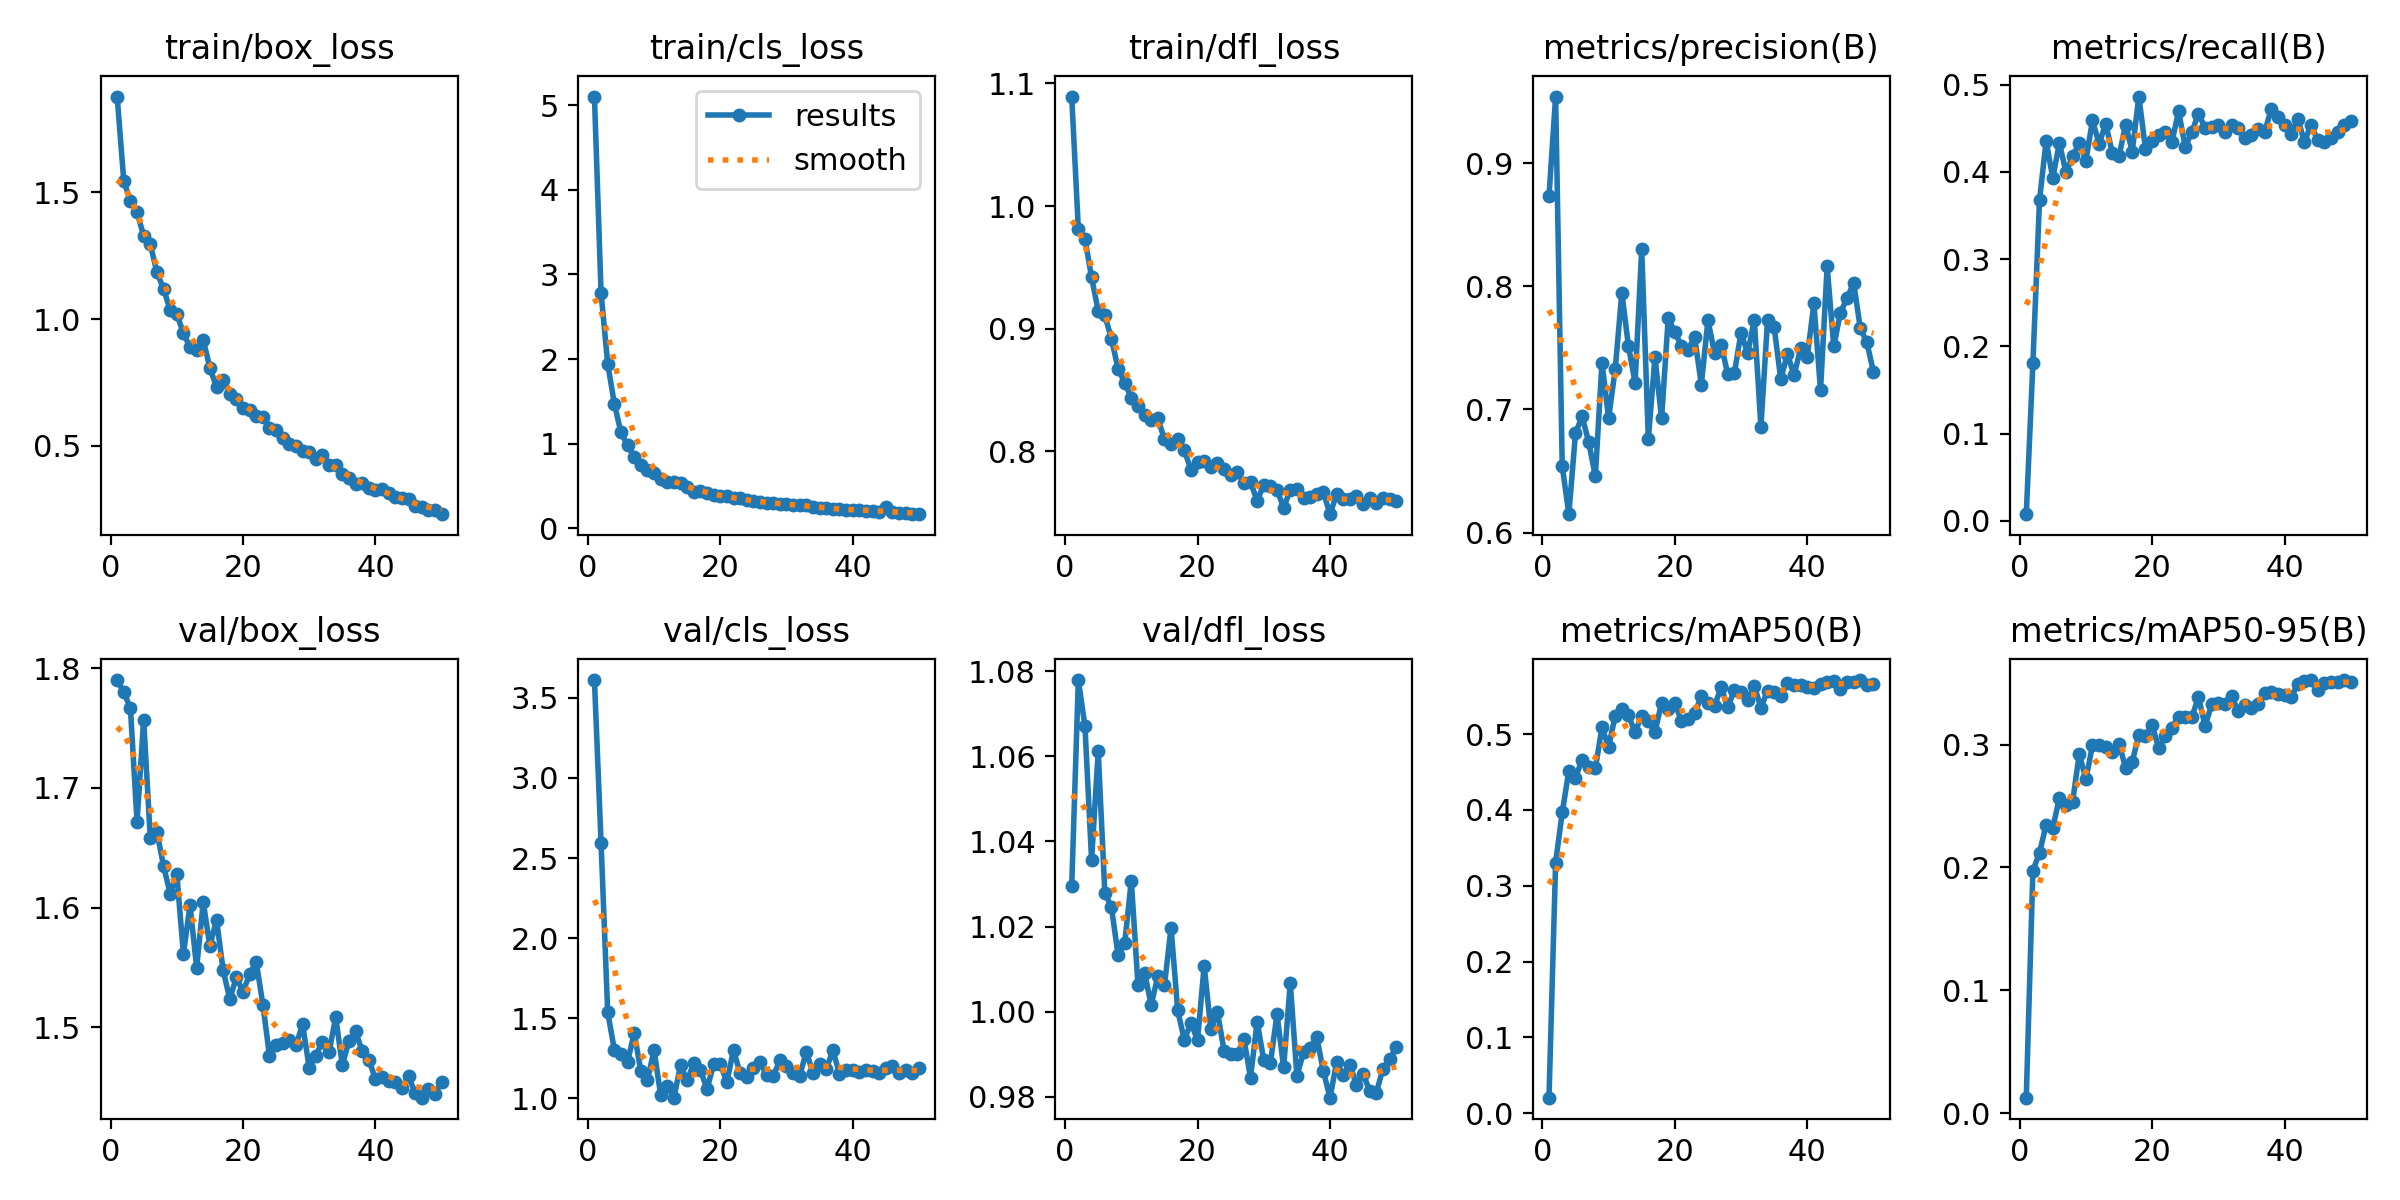


Precision-Recall Curve:


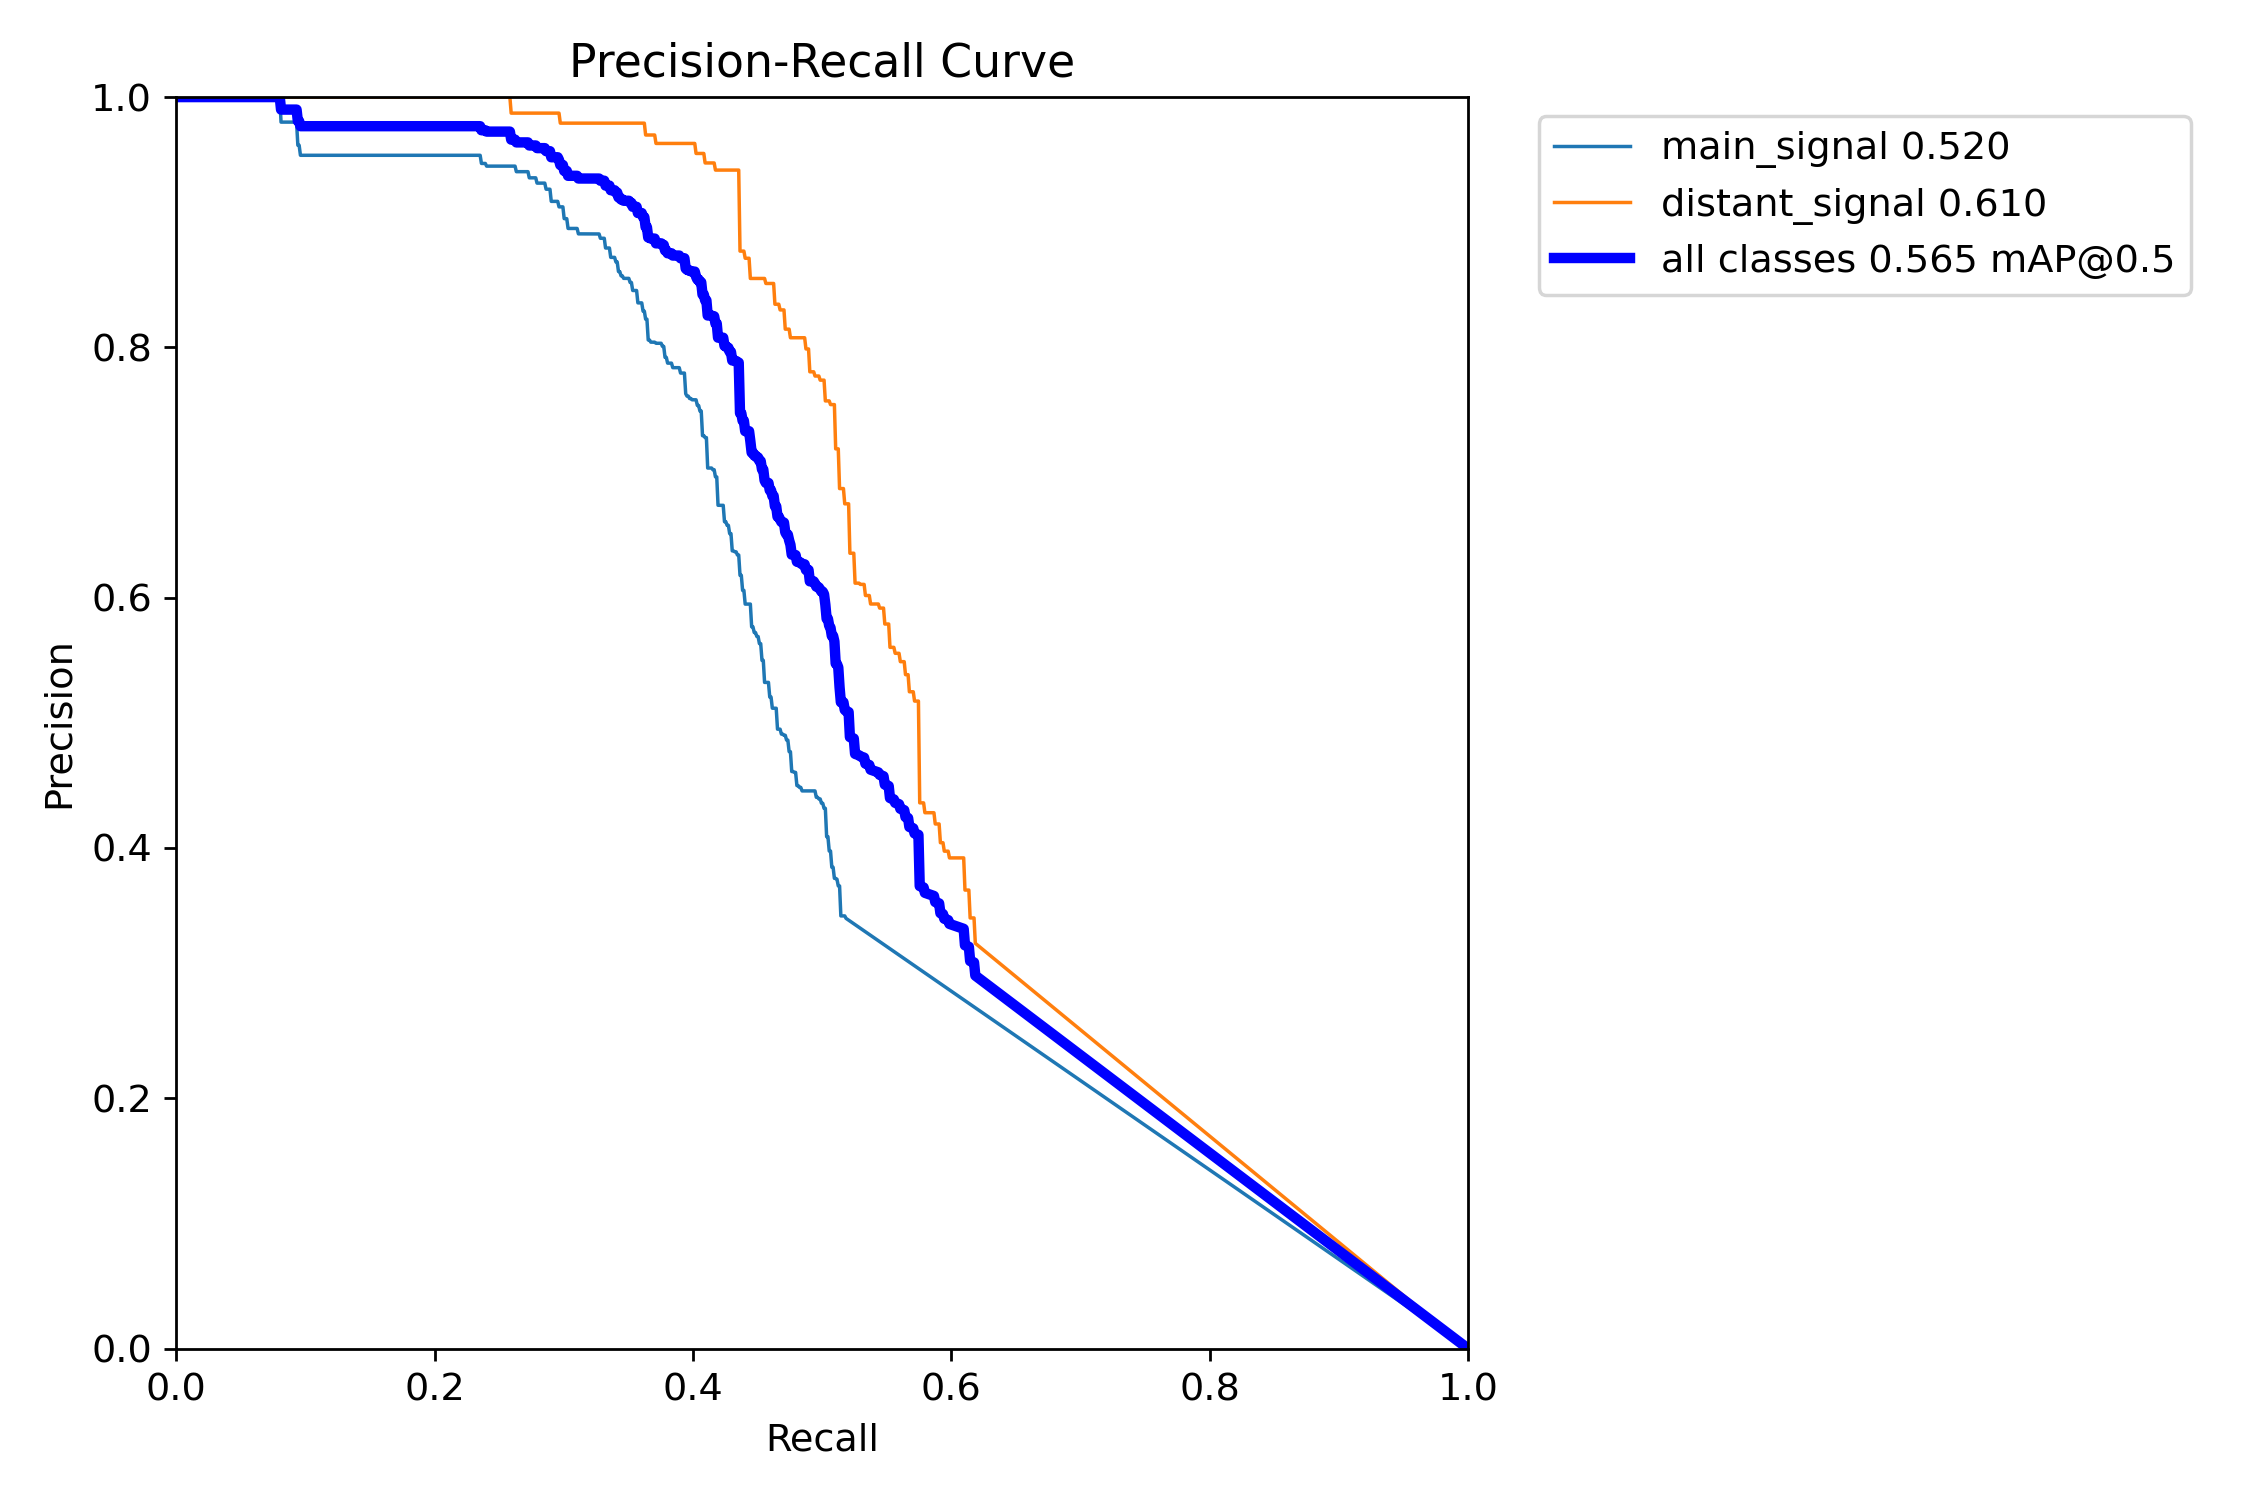


F1 Curve:


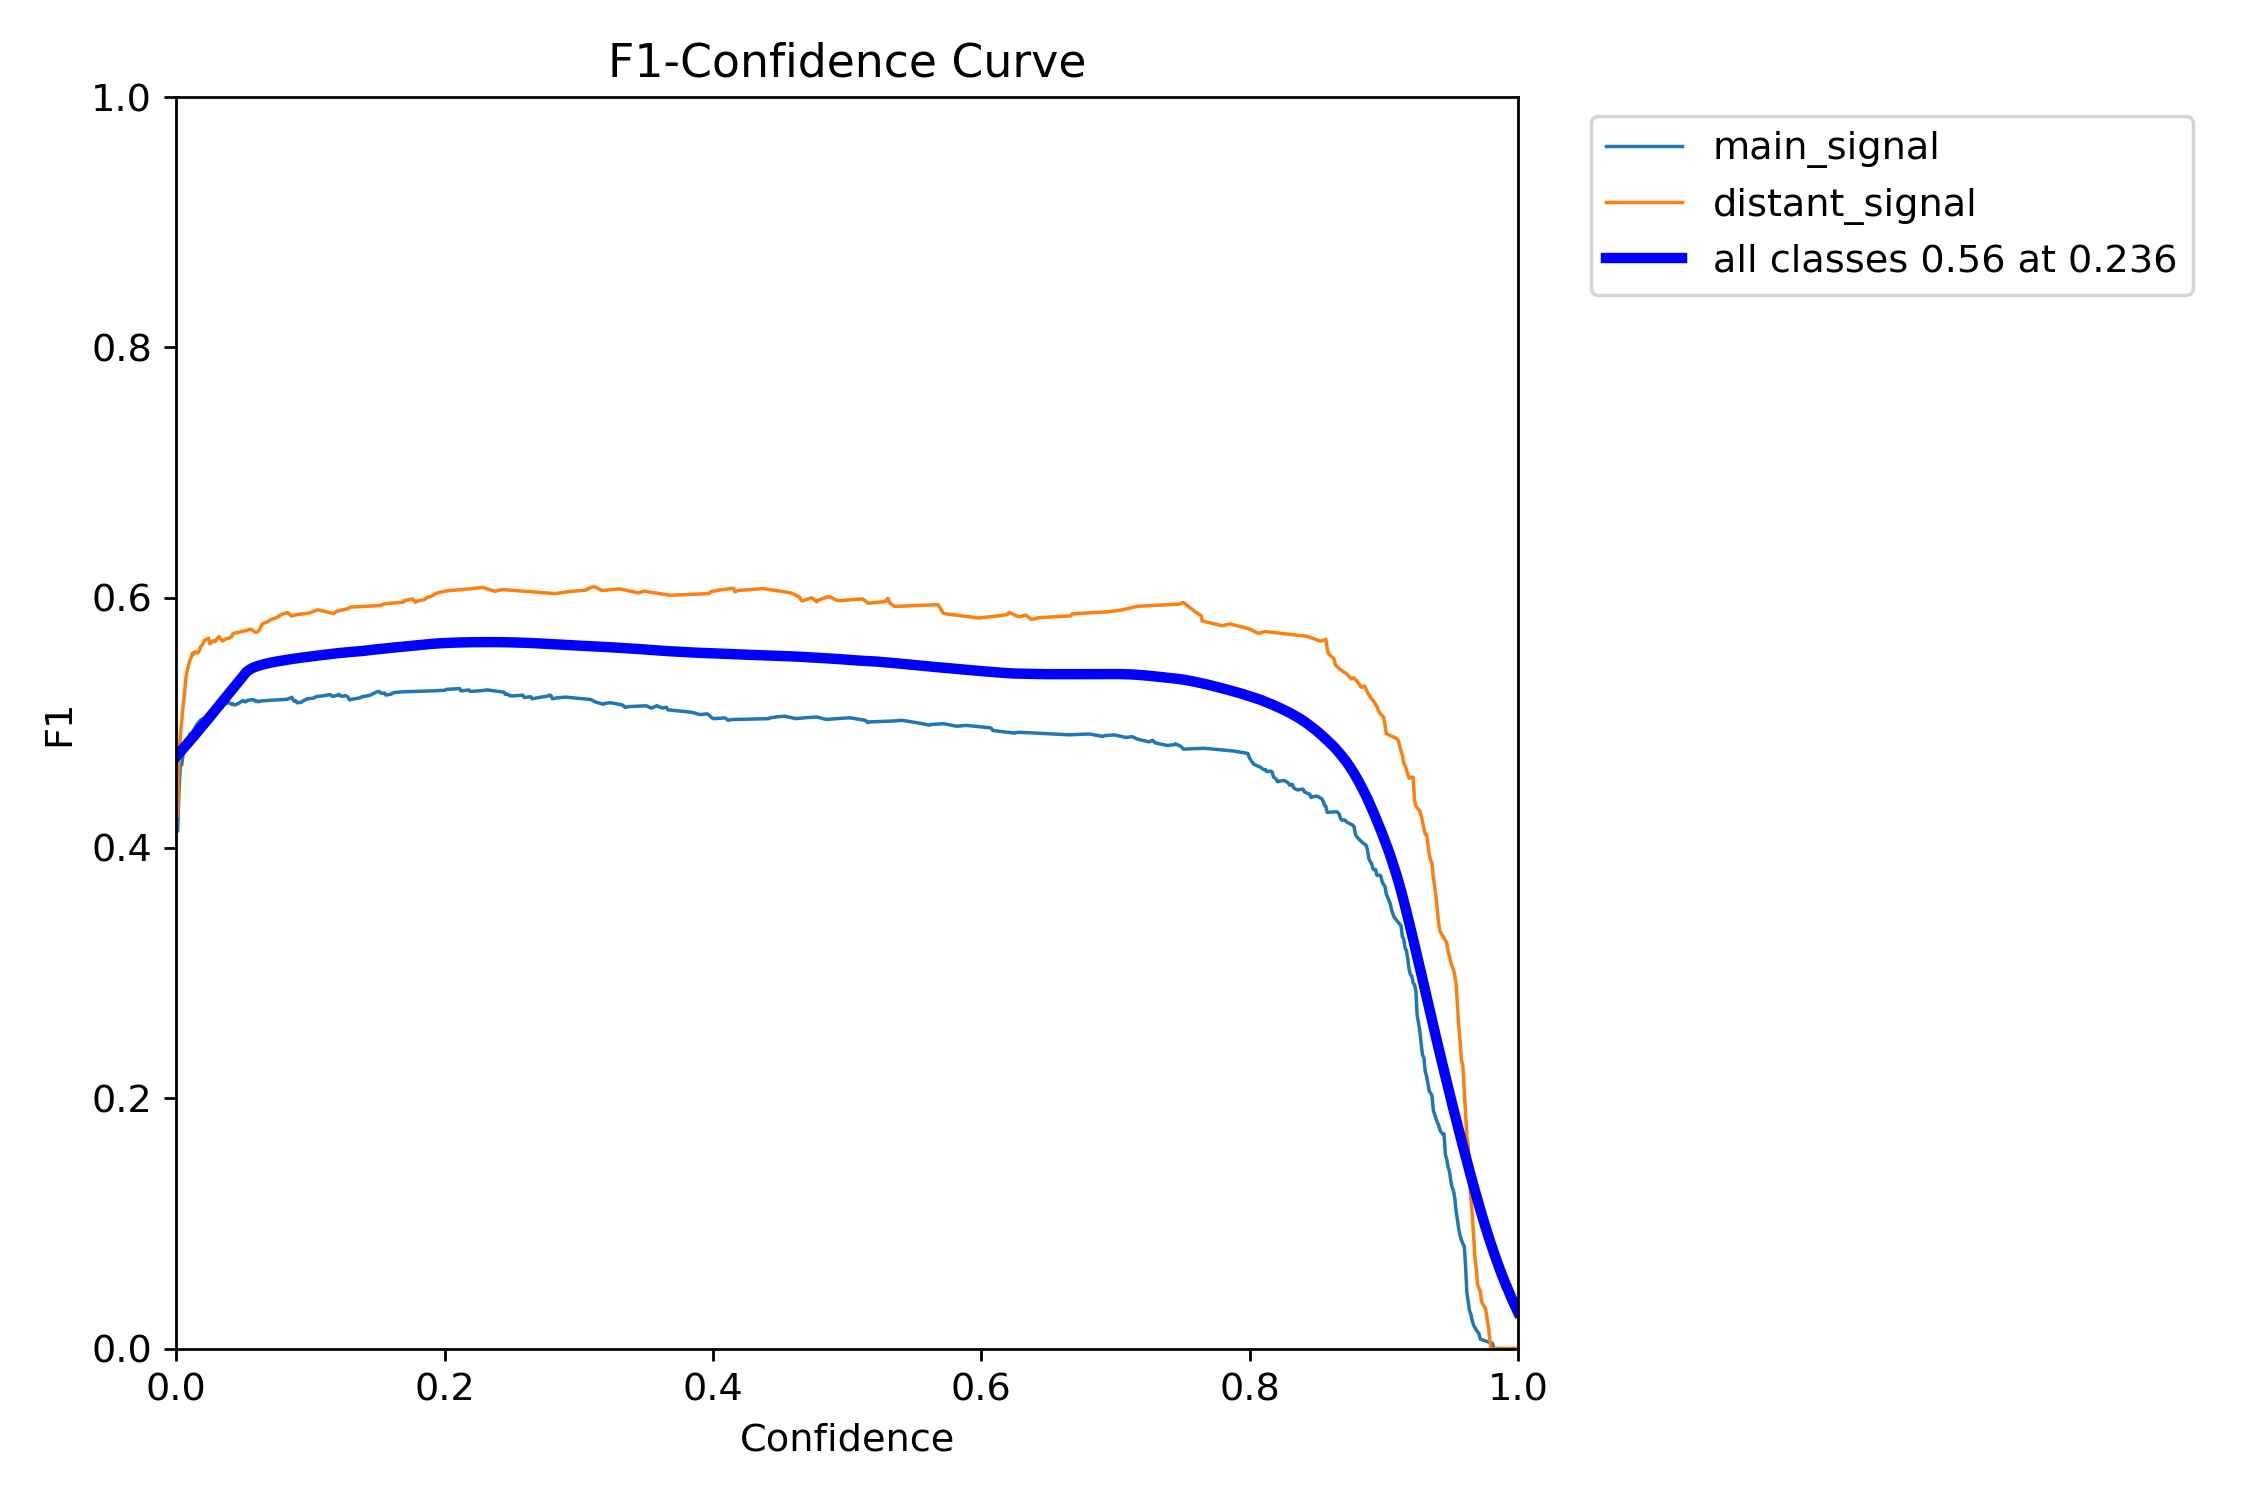


Confusion Matrix (Baseline):


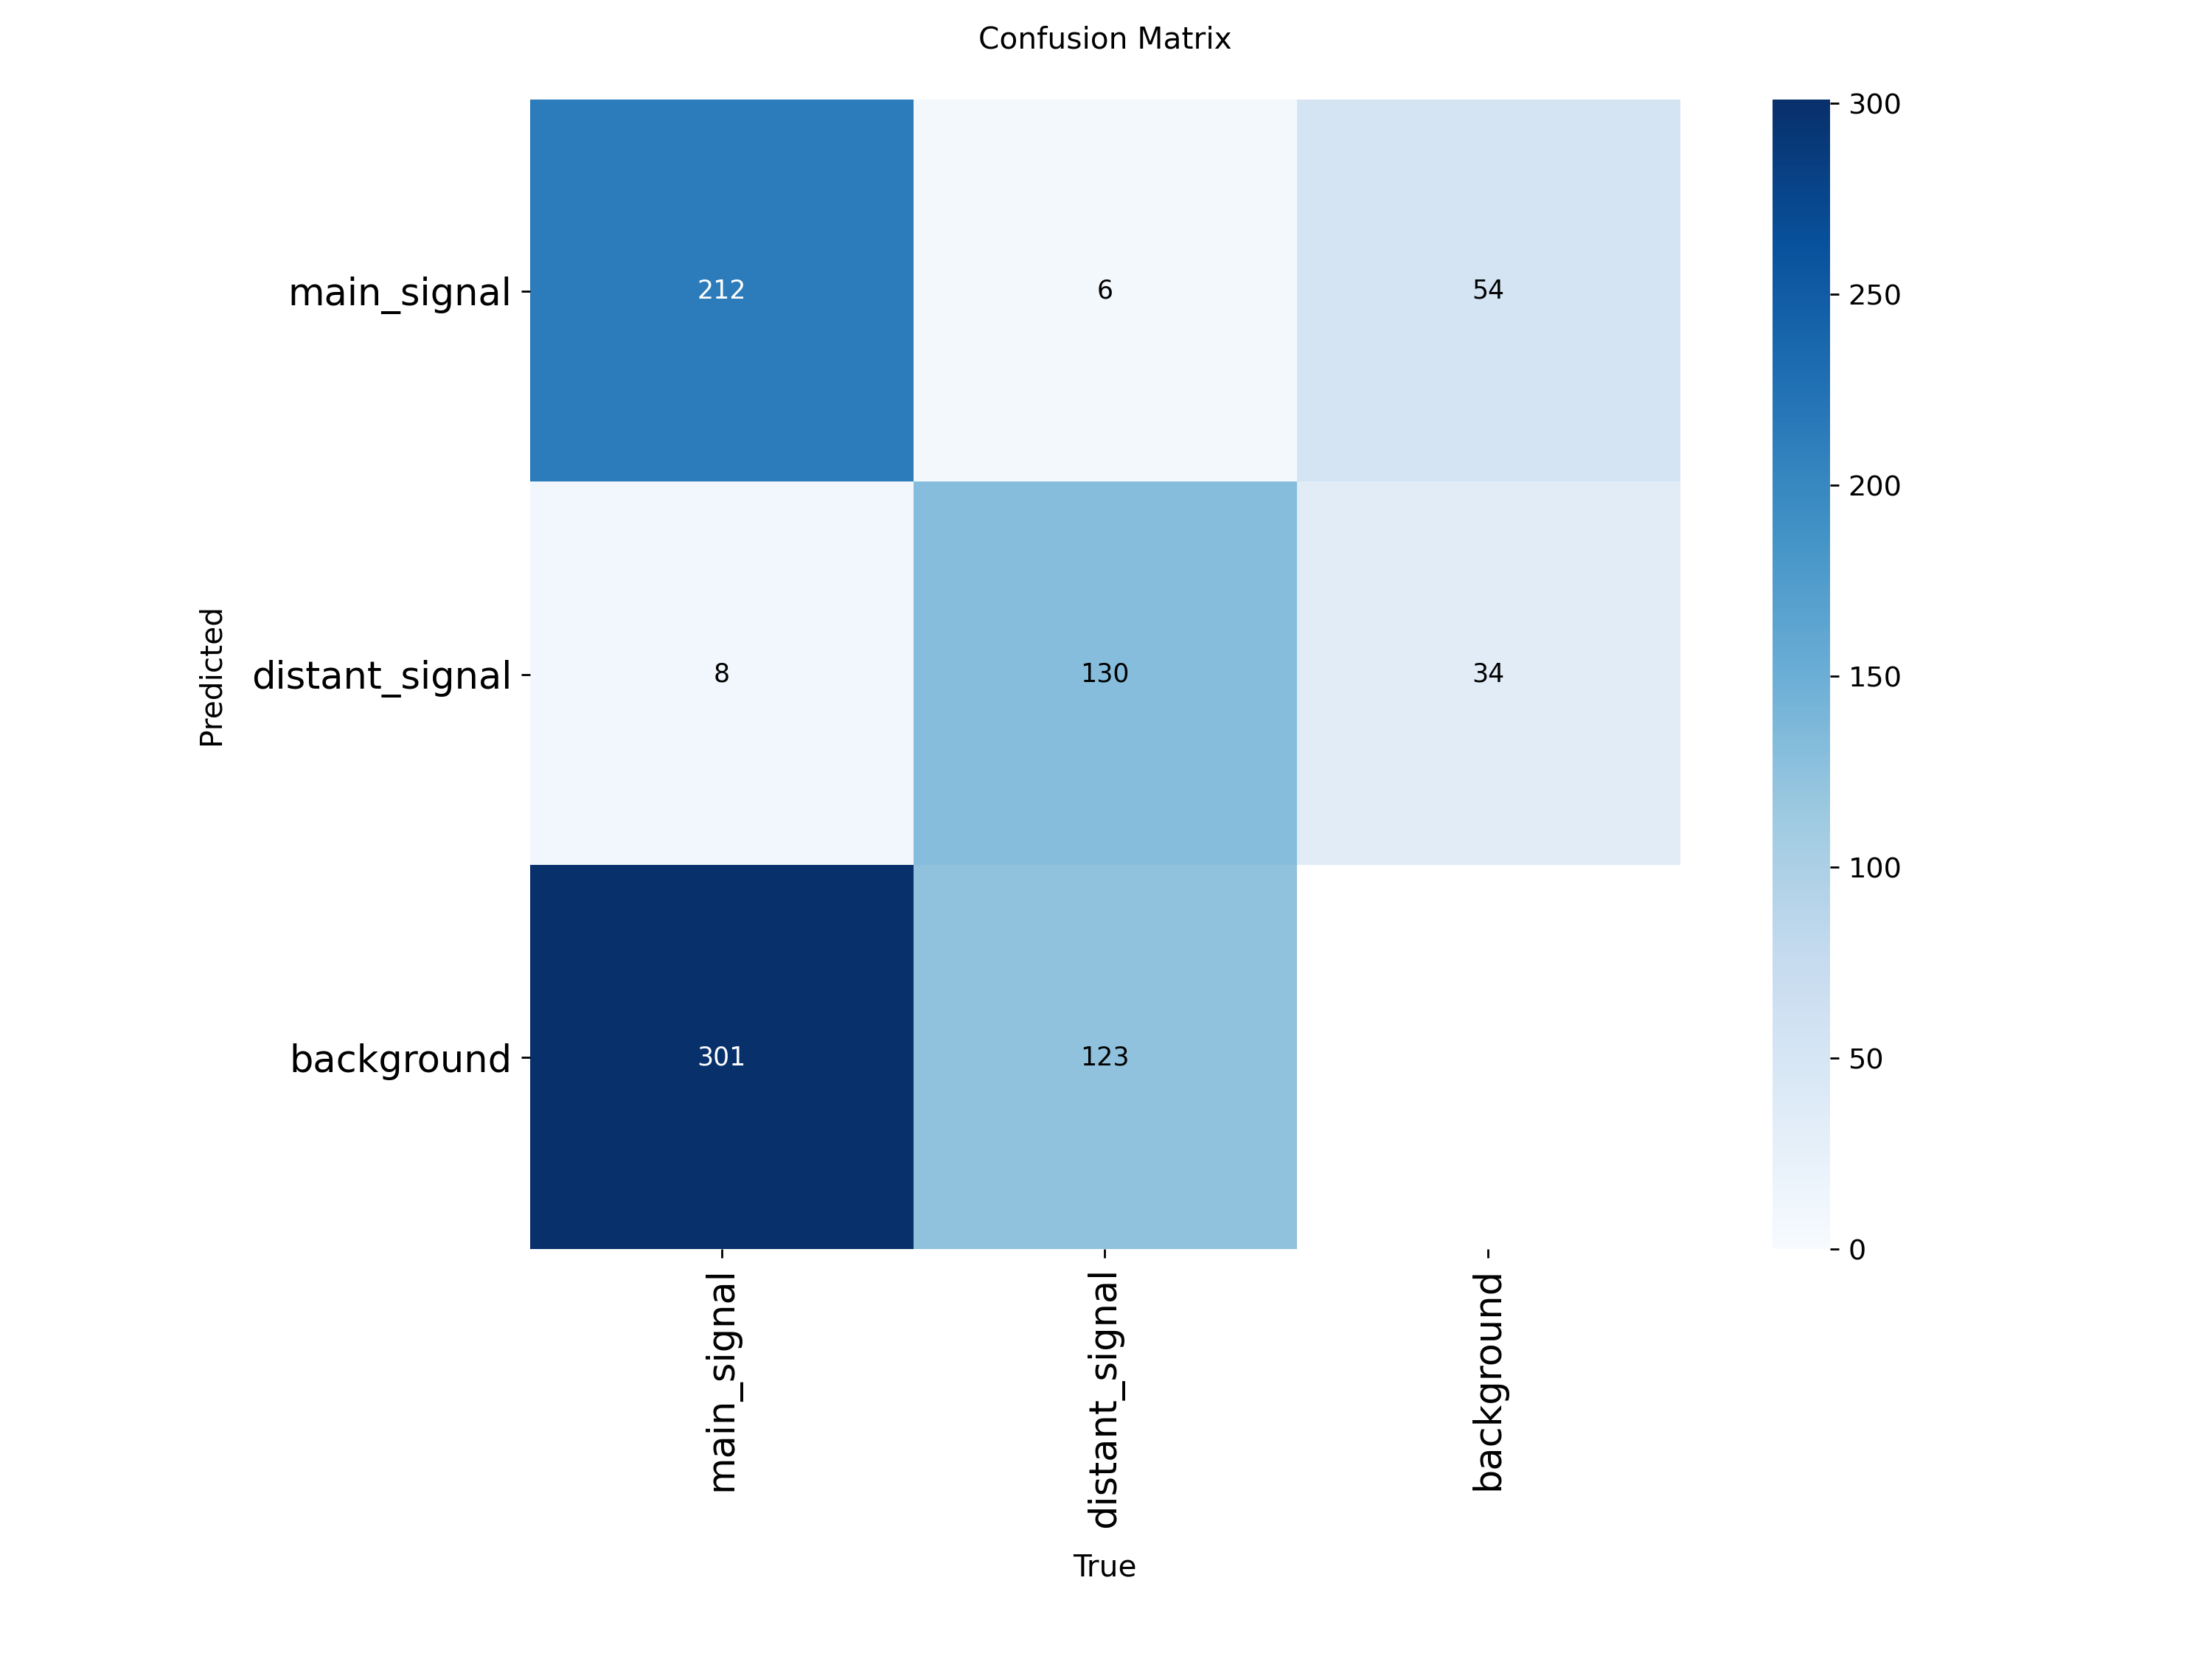

In [13]:
#Display Baseline Training Curves

from IPython.display import Image, display

run_name = "signal_baseline_no_aug"

print("Training Results (Baseline):")
display(Image(filename=f"runs/detect/{run_name}/results.png"))

print("\nPrecision-Recall Curve:")
display(Image(filename=f"runs/detect/{run_name}/BoxPR_curve.png"))

print("\nF1 Curve:")
display(Image(filename=f"runs/detect/{run_name}/BoxF1_curve.png"))

print("\nConfusion Matrix (Baseline):")
display(Image(filename=f"runs/detect/{run_name}/confusion_matrix.png"))


In [14]:
# Train Weather-Augmented YOLO Model

from ultralytics import YOLO
import time

start_time_aug = time.time()

model_aug = YOLO("yolov8n.pt")

aug_results = model_aug.train(
    data="/content/GERALD_subset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=32,
    cache=True,
    workers=8,
    patience=15,

    # WEATHER AUGMENTATION
    degrees=15,
    scale=0.5,
    shear=5,
    flipud=0.2,
    fliplr=0.5,
    mixup=0.3,
    mosaic=1.0,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.5,
    name="signal_augmented",
    save_txt=True,
    save_conf=True,
)

elapsed_aug = (time.time() - start_time_aug) / 60
print(f"\nAugmented training completed in {elapsed_aug:.1f} minutes")


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/GERALD_subset/data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.2, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=signal_augmented, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots=

In [15]:
# Per-Weather Evaluation (Augmented Model)

print("Evaluating Augmented Model per Weather Condition!!!!\n")

# Load augmented model
augmented_model = YOLO("/content/runs/detect/signal_augmented/weights/best.pt")

augmented_weather_results = {}

for weather, img_list in weather_image_groups.items():
    if len(img_list) < 5:
        continue

    print(f"  Evaluating {weather} ({len(img_list)} images)...", end=" ")

    # Run inference
    results_list = []
    for img_name in img_list:
        img_path = val_dir / img_name
        if img_path.exists():
            result = augmented_model.predict(
                source=str(img_path),
                save=False,
                verbose=False,
                conf=0.25
            )
            results_list.append(result[0])

    total_detections = sum([len(r.boxes) for r in results_list])
    avg_confidence = sum([r.boxes.conf.mean().item() if len(r.boxes) > 0 else 0
                          for r in results_list]) / len(results_list)

    augmented_weather_results[weather] = {
        'images': len(img_list),
        'total_detections': total_detections,
        'avg_detections_per_image': total_detections / len(img_list),
        'avg_confidence': avg_confidence
    }


print("\n" + "="*70)
print("AUGMENTED MODEL - WEATHER-SPECIFIC PERFORMANCE")
print("="*70)

df_augmented = pd.DataFrame(augmented_weather_results).T
df_augmented = df_augmented.round(3)
print(df_augmented.to_string())

Evaluating Augmented Model per Weather Condition!!!!

  Evaluating Sunny (67 images)...   Evaluating Rainy (95 images)...   Evaluating Cloudy (118 images)...   Evaluating Foggy (33 images)...   Evaluating Snowy (34 images)...   Evaluating Unknown (51 images)... 
AUGMENTED MODEL - WEATHER-SPECIFIC PERFORMANCE
         images  total_detections  avg_detections_per_image  avg_confidence
Sunny      67.0             107.0                     1.597           0.530
Rainy      95.0             131.0                     1.379           0.532
Cloudy    118.0             176.0                     1.492           0.521
Foggy      33.0              36.0                     1.091           0.534
Snowy      34.0              50.0                     1.471           0.605
Unknown    51.0              39.0                     0.765           0.252


Training Results (Augmented):


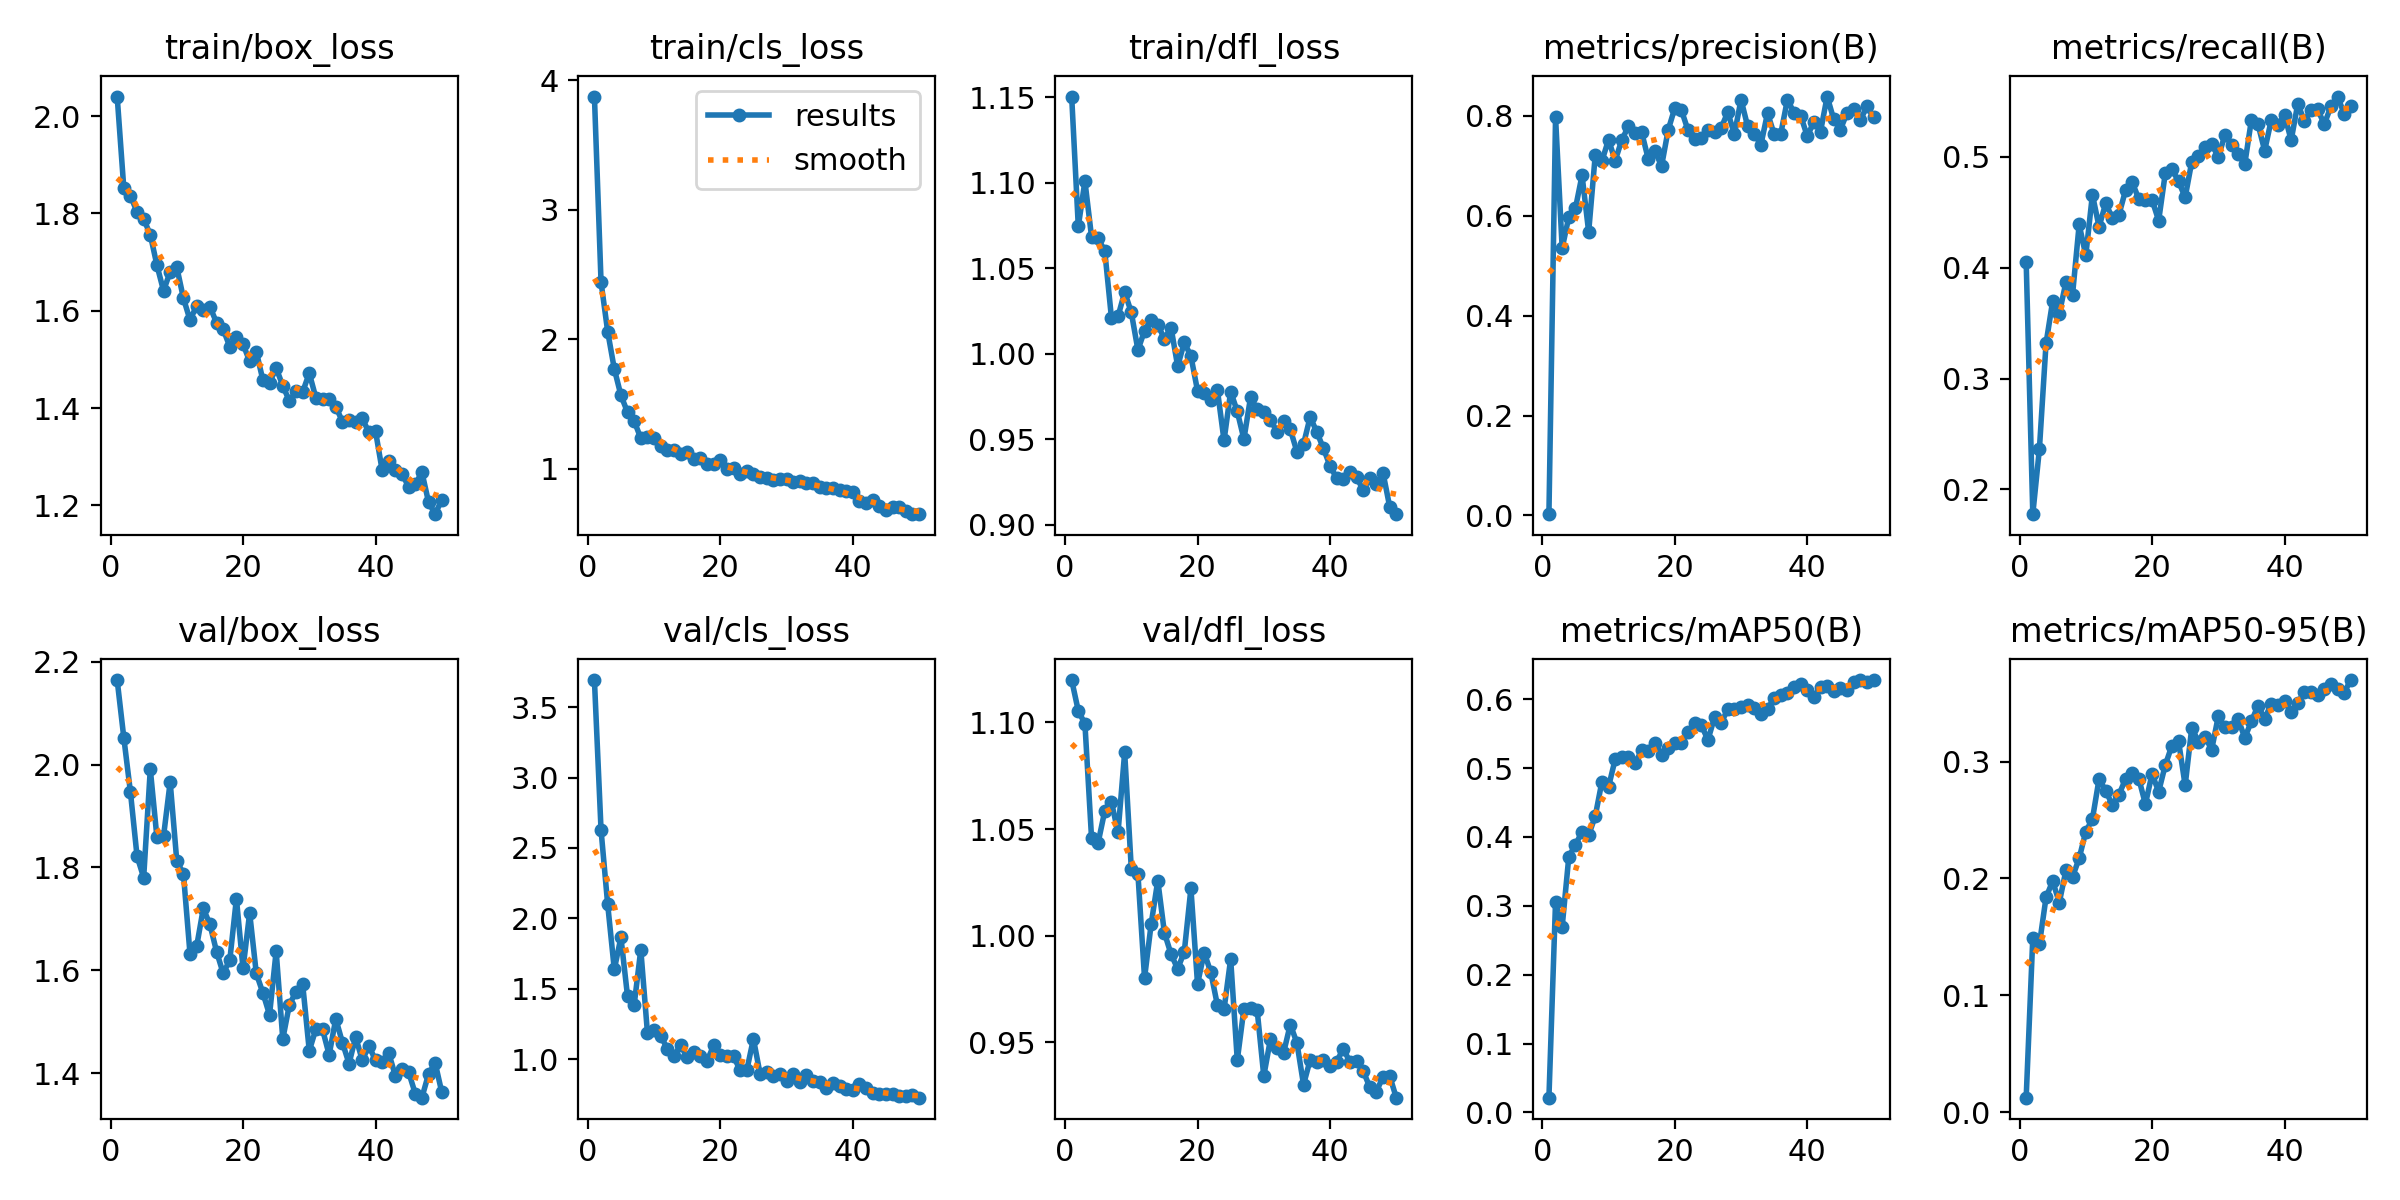


Confusion Matrix (Augmented):


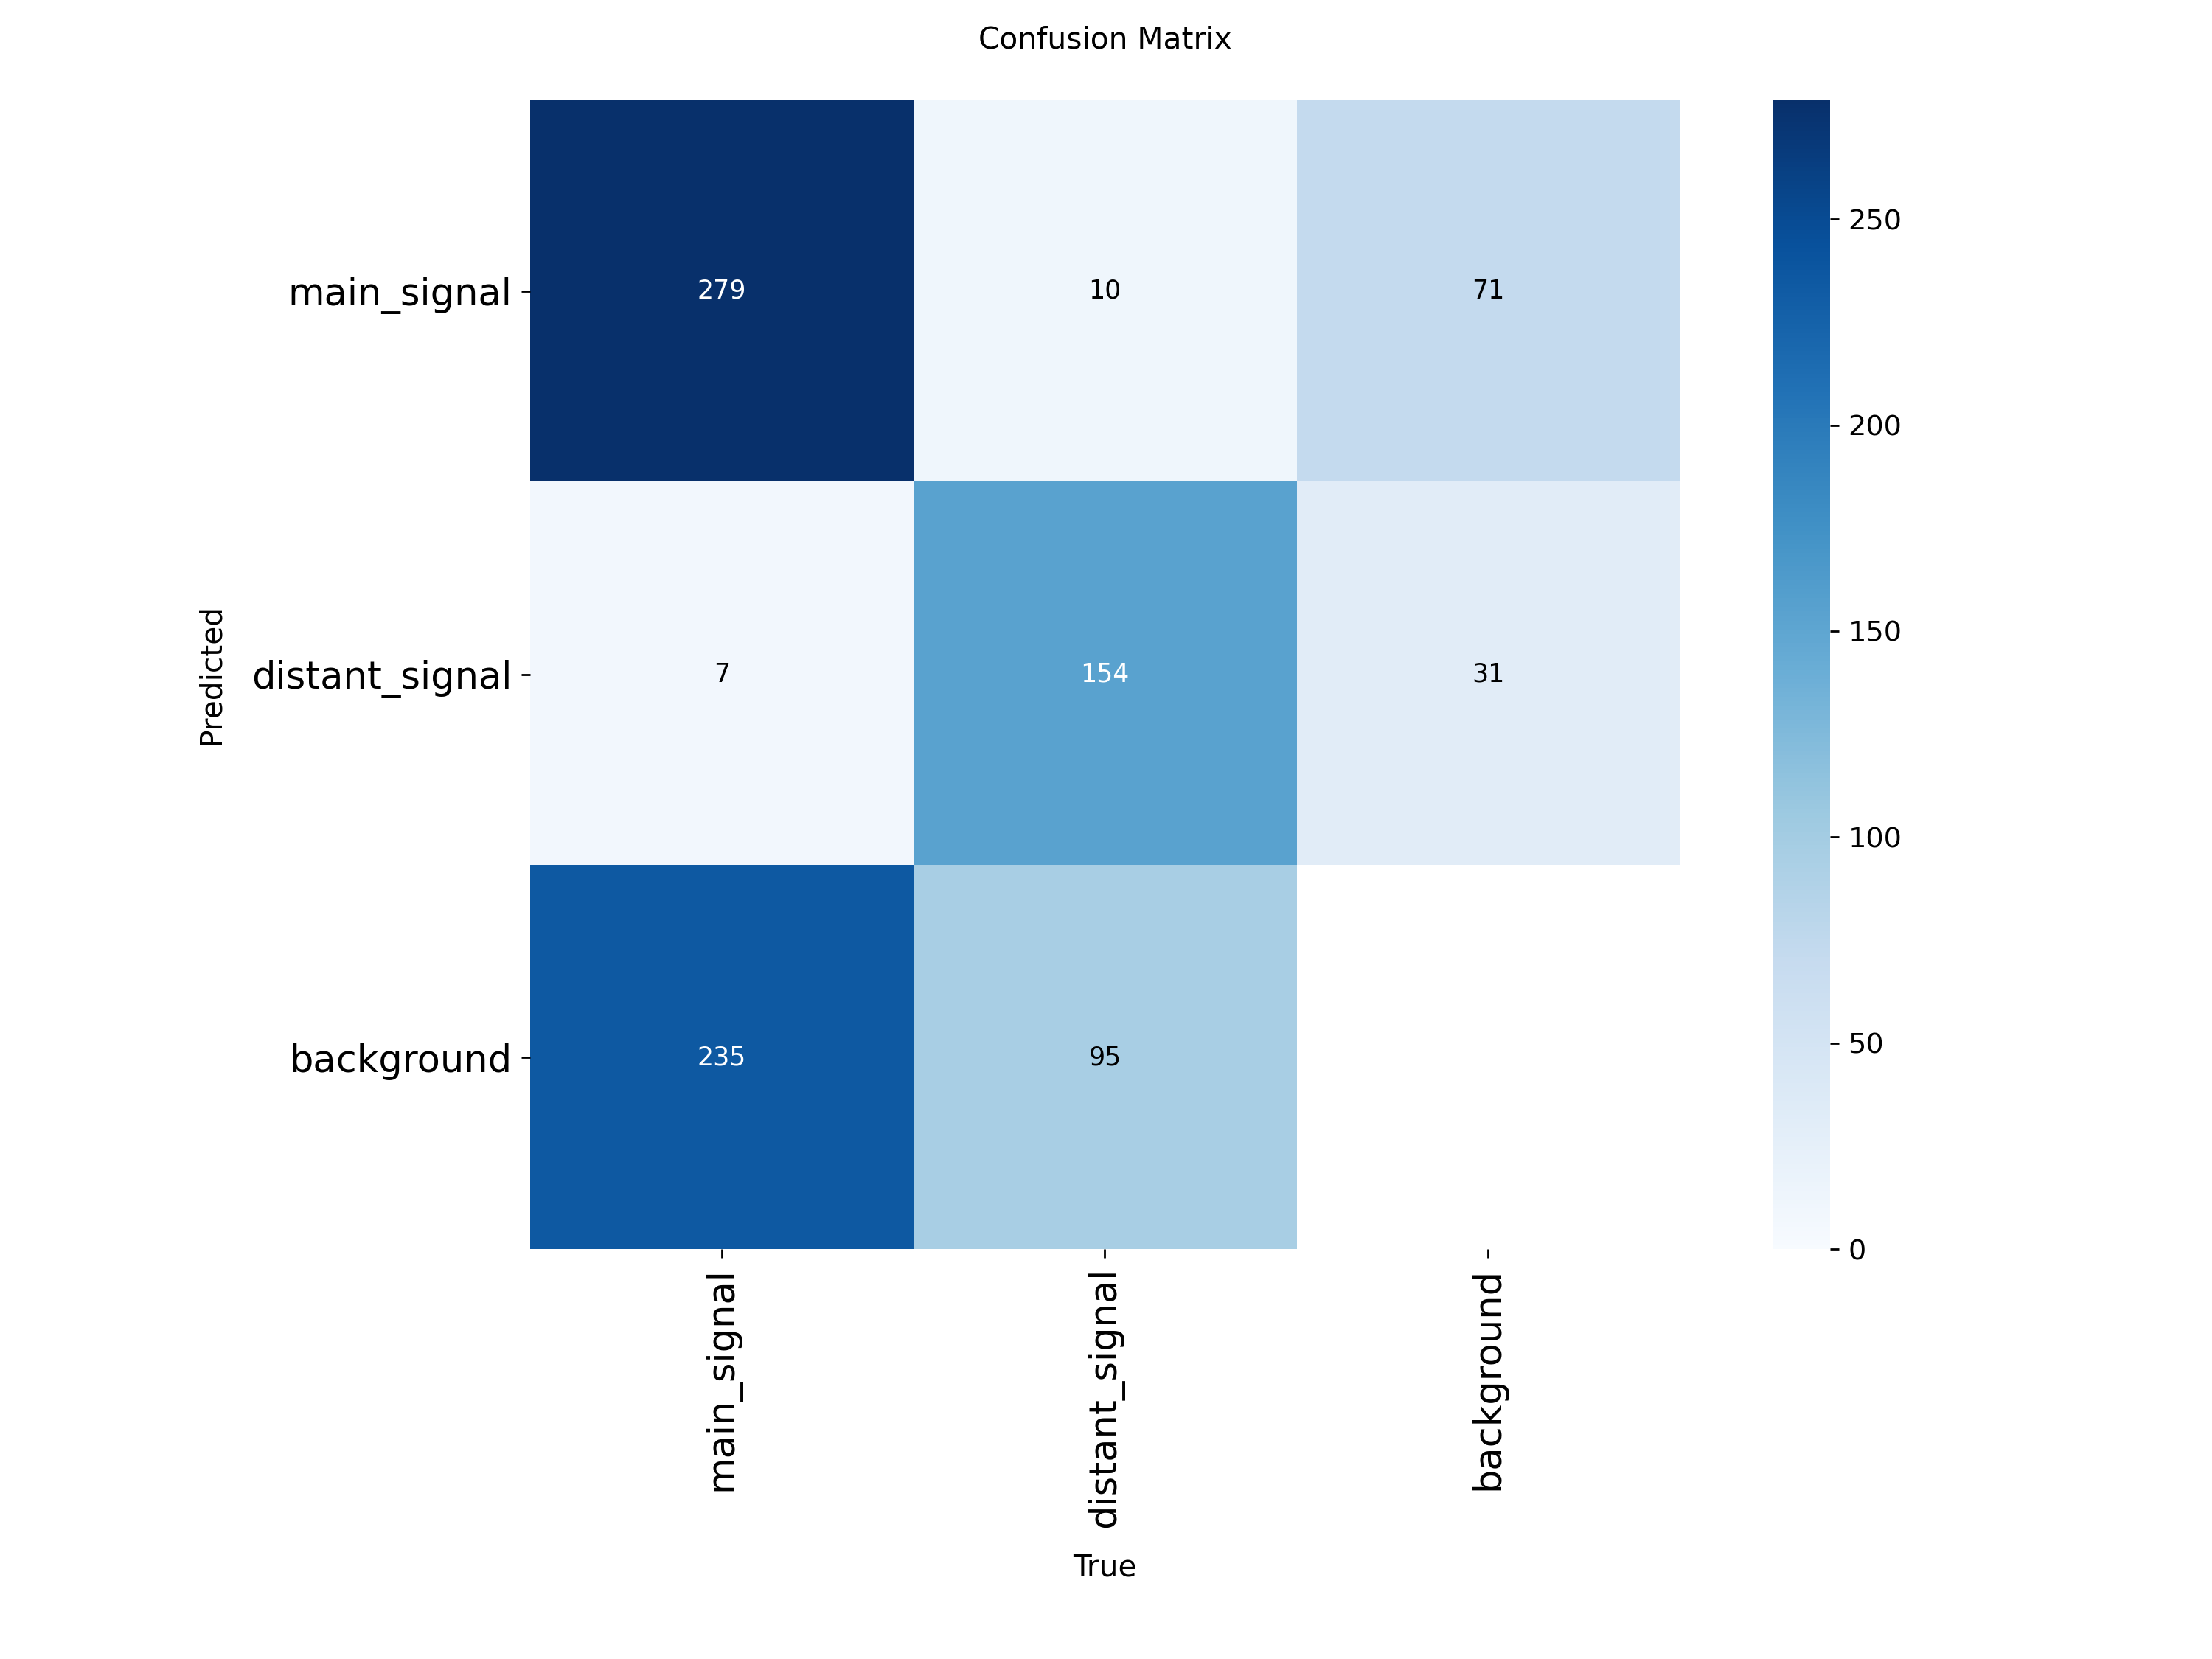

In [16]:
aug_run = "signal_augmented"

print("Training Results (Augmented):")
display(Image(filename=f"runs/detect/{aug_run}/results.png"))

print("\nConfusion Matrix (Augmented):")
display(Image(filename=f"runs/detect/{aug_run}/confusion_matrix.png"))



BASELINE vs AUGMENTED - WEATHER COMPARISON

Average Detections per Image:
Weather         Baseline     Augmented    Improvement 
-------------------------------------------------------
Cloudy          1.17         1.49         +27.5%
Foggy           1.12         1.09         -2.7%
Rainy           1.16         1.38         +19.1%
Snowy           1.50         1.47         -2.0%
Sunny           1.10         1.60         +44.6%
Unknown         0.51         0.76         +50.0%


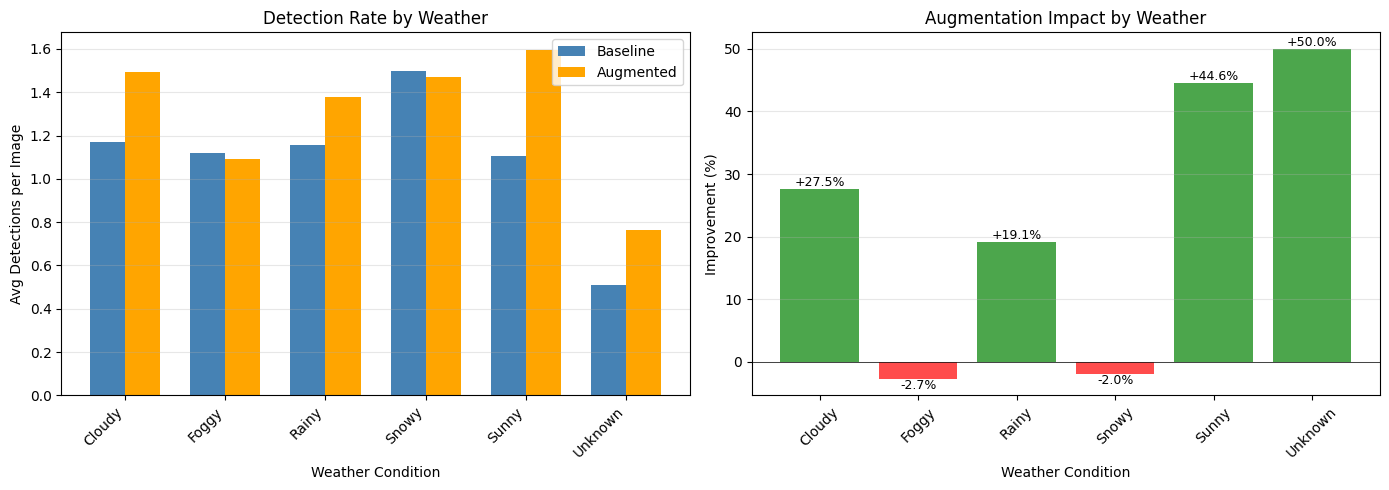


Saved comparison chart: /content/weather_comparison.png

Key Findings:
Biggest improvement: Unknown (+50.0%)
Degradation in: Foggy (-2.7%)
Average improvement: +22.8%


In [17]:
#Comparison Baseline vs Augmented per Weather

import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*70)
print("BASELINE vs AUGMENTED - WEATHER COMPARISON")
print("="*70)

# Prepare comparison data
weather_conditions = sorted(baseline_weather_results.keys())

baseline_detections = [baseline_weather_results[w]['avg_detections_per_image']
                       for w in weather_conditions]
augmented_detections = [augmented_weather_results[w]['avg_detections_per_image']
                        for w in weather_conditions]

baseline_confidence = [baseline_weather_results[w]['avg_confidence']
                       for w in weather_conditions]
augmented_confidence = [augmented_weather_results[w]['avg_confidence']
                        for w in weather_conditions]

# Calculate improvement
improvements = [(aug - base) / base * 100 if base > 0 else 0
                for base, aug in zip(baseline_detections, augmented_detections)]

# Print comparison table
print("\nAverage Detections per Image:")
print(f"{'Weather':<15} {'Baseline':<12} {'Augmented':<12} {'Improvement':<12}")
print("-" * 55)
for i, weather in enumerate(weather_conditions):
    print(f"{weather:<15} {baseline_detections[i]:<12.2f} {augmented_detections[i]:<12.2f} "
          f"{improvements[i]:+.1f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Detections comparison
x = np.arange(len(weather_conditions))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, baseline_detections, width, label='Baseline', color='steelblue')
bars2 = ax1.bar(x + width/2, augmented_detections, width, label='Augmented', color='orange')

ax1.set_xlabel('Weather Condition')
ax1.set_ylabel('Avg Detections per Image')
ax1.set_title('Detection Rate by Weather')
ax1.set_xticks(x)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Improvement percentage
ax2 = axes[1]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
bars = ax2.bar(weather_conditions, improvements, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Weather Condition')
ax2.set_ylabel('Improvement (%)')
ax2.set_title('Augmentation Impact by Weather')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.1f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9)

plt.tight_layout()
plt.savefig('/content/weather_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved comparison chart: /content/weather_comparison.png")

# Identify best improvements
print("\nKey Findings:")
best_improvement_idx = np.argmax(improvements)
print(f"Biggest improvement: {weather_conditions[best_improvement_idx]} "
      f"({improvements[best_improvement_idx]:+.1f}%)")

worst_improvement_idx = np.argmin(improvements)
if improvements[worst_improvement_idx] < 0:
    print(f"Degradation in: {weather_conditions[worst_improvement_idx]} "
          f"({improvements[worst_improvement_idx]:+.1f}%)")

avg_improvement = np.mean(improvements)
print(f"Average improvement: {avg_improvement:+.1f}%")

In [19]:
from ultralytics import YOLO
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
from statistics import mean
import torch

print("\nRunning Weather Adaptive Confidence Threshold Optimization!!!\n")

# Load both models
baseline_model = YOLO("/content/runs/detect/signal_baseline_no_aug/weights/best.pt")
aug_model = YOLO("/content/runs/detect/signal_augmented/weights/best.pt")

dataset_root = Path("/content/GERALD_subset")
ann_dir = dataset_root / "annotations"
val_dir = dataset_root / "val" / "images"

# Get validation images grouped by weather condition
weather_groups = defaultdict(list)
val_imgs = {img.name for img in val_dir.glob("*.jpg")}

for xml_file in ann_dir.glob("*.xml"):
    try:
        root = ET.parse(xml_file).getroot()
        img_name = root.find("filename").text
        if img_name in val_imgs:
            weather = root.find("metadata").find("weather").text
            weather_groups[weather].append(img_name)
    except:
        continue

thresholds = np.arange(0.10, 0.90, 0.05)


def calculate_iou(box1, box2):
    """
    Calculate IoU between two boxes in xyxy format.
    box1, box2: [x1, y1, x2, y2]
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0.0

    return inter_area / union_area


def get_ground_truth_boxes(xml_path, img_width, img_height):
    """
    Extract ground truth boxes from XML annotation.
    Returns list of boxes in xyxy format (pixel coordinates).
    """
    try:
        root = ET.parse(xml_path).getroot()
        gt_boxes = []

        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)
            gt_boxes.append([xmin, ymin, xmax, ymax])

        return gt_boxes
    except:
        return []


def calculate_metrics_with_iou(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Calculate TP, FP, FN using IoU matching.

    Args:
        pred_boxes: List of predicted boxes [x1, y1, x2, y2]
        gt_boxes: List of ground truth boxes [x1, y1, x2, y2]
        iou_threshold: IoU threshold for considering a match (default 0.5)

    Returns:
        tp, fp, fn counts
    """
    if len(pred_boxes) == 0 and len(gt_boxes) == 0:
        return 0, 0, 0

    if len(pred_boxes) == 0:
        return 0, 0, len(gt_boxes)

    if len(gt_boxes) == 0:
        return 0, len(pred_boxes), 0

    # Match predictions to ground truths
    gt_matched = [False] * len(gt_boxes)
    tp = 0
    fp = 0

    for pred_box in pred_boxes:
        best_iou = 0
        best_gt_idx = -1

        # Find best matching ground truth
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_matched[gt_idx]:
                continue

            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx

        # Check if match is good enough
        if best_iou >= iou_threshold:
            tp += 1
            gt_matched[best_gt_idx] = True
        else:
            fp += 1

    # Count unmatched ground truths as false negatives
    fn = sum(1 for matched in gt_matched if not matched)

    return tp, fp, fn


def evaluate_model_fixed(model, weather_groups):
    """
    For a given YOLO model, compute optimal confidence threshold per weather condition.
    FIXED VERSION: Uses proper IoU-based precision/recall calculation.
    """
    results = {}

    for weather, img_list in weather_groups.items():
        if len(img_list) < 5:
            continue

        print(f"  Processing {weather} ({len(img_list)} images)...")
        weather_stats = []

        for conf_t in thresholds:
            total_tp = 0
            total_fp = 0
            total_fn = 0

            for img_name in img_list:
                img_path = val_dir / img_name
                if not img_path.exists():
                    continue

                # Run prediction
                pred = model.predict(source=str(img_path), conf=conf_t, verbose=False)
                det = pred[0].boxes

                # Get predicted boxes (xyxy format)
                if len(det) > 0:
                    pred_boxes = det.xyxy.cpu().numpy().tolist()
                else:
                    pred_boxes = []

                # Get ground truth boxes
                xml_path = ann_dir / (img_name.replace(".jpg", ".xml"))

                # Get image dimensions for proper box extraction
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()
                    img_width = int(root.find("size/width").text)
                    img_height = int(root.find("size/height").text)
                    gt_boxes = get_ground_truth_boxes(xml_path, img_width, img_height)
                except:
                    gt_boxes = []


                tp, fp, fn = calculate_metrics_with_iou(pred_boxes, gt_boxes, iou_threshold=0.5)

                total_tp += tp
                total_fp += fp
                total_fn += fn

            # Calculate precision and recall over entire weather group
            precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
            recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

            weather_stats.append((conf_t, precision, recall, f1, total_tp, total_fp, total_fn))

        # Pick the threshold with the best F1 score
        best_stats = max(weather_stats, key=lambda x: x[3])
        opt_thr, opt_p, opt_r, opt_f1, tp, fp, fn = best_stats

        results[weather] = {
            "optimal_threshold": round(opt_thr, 3),
            "precision_at_opt": round(opt_p, 3),
            "recall_at_opt": round(opt_r, 3),
            "f1_at_opt": round(opt_f1, 3),
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "samples": len(img_list)
        }

    return pd.DataFrame(results).T


# Apply WACT to both models
print("Optimizing thresholds for Baseline Model!!!!")
df_baseline_wact = evaluate_model_fixed(baseline_model, weather_groups)

print("\nOptimizing thresholds for Augmented Model!!!!")
df_aug_wact = evaluate_model_fixed(aug_model, weather_groups)

print("\n" + "="*70)
print("WEATHER-ADAPTIVE CONFIDENCE OPTIMIZATION RESULTS")
print("="*70)

print("\n--- Baseline Model ---")
print(df_baseline_wact.to_string())

print("\n--- Augmented Model ---")
print(df_aug_wact.to_string())

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)

# Analyze threshold patterns
print("\nOptimal Threshold by Weather (Augmented Model):")
thresholds_sorted = df_aug_wact.sort_values('optimal_threshold', ascending=False)
for weather in thresholds_sorted.index:
    threshold = thresholds_sorted.loc[weather, 'optimal_threshold']
    f1 = thresholds_sorted.loc[weather, 'f1_at_opt']
    print(f"  {weather:15s}: {threshold:.2f} (F1={f1:.3f})")

print("\nInterpretation:")
print("Higher thresholds in good weather -> model is more confident")
print("Lower thresholds in adverse weather -> need to be more permissive")
print("This validates weather adaptive thresholding approach")

# Compare baseline vs augmented
print("\n" + "="*70)
print("BASELINE vs AUGMENTED - Threshold Comparison:")
print("="*70)
comparison_df = pd.DataFrame({
    'Baseline_Threshold': df_baseline_wact['optimal_threshold'],
    'Augmented_Threshold': df_aug_wact['optimal_threshold'],
    'Baseline_F1': df_baseline_wact['f1_at_opt'],
    'Augmented_F1': df_aug_wact['f1_at_opt'],
})
print(comparison_df.to_string())

print("\nWACT optimization complete!")





Running Weather Adaptive Confidence Threshold Optimization!!!

Optimizing thresholds for Baseline Model!!!!
  Processing Sunny (67 images)...
  Processing Rainy (95 images)...
  Processing Cloudy (118 images)...
  Processing Foggy (33 images)...
  Processing Snowy (34 images)...
  Processing Unknown (51 images)...

Optimizing thresholds for Augmented Model!!!!
  Processing Sunny (67 images)...
  Processing Rainy (95 images)...
  Processing Cloudy (118 images)...
  Processing Foggy (33 images)...
  Processing Snowy (34 images)...
  Processing Unknown (51 images)...

WEATHER-ADAPTIVE CONFIDENCE OPTIMIZATION RESULTS (FIXED)

--- Baseline Model ---
         optimal_threshold  precision_at_opt  recall_at_opt  f1_at_opt     TP    FP     FN  samples
Sunny                 0.15             0.785          0.470      0.588   62.0  17.0   70.0     67.0
Rainy                 0.25             0.800          0.492      0.609   88.0  22.0   91.0     95.0
Cloudy                0.10             0.813  

APPLYING WACT THRESHOLDS FOR FINAL WEATHER EVALUATION

 WACT IMPROVEMENT TABLE

         Base_Fixed_Thr  Base_WACT_Thr  Base_F1_Fixed  Base_F1_WACT  Base_F1_Improvement(%)  Aug_Fixed_Thr  Aug_WACT_Thr  Aug_F1_Fixed  Aug_F1_WACT  Aug_F1_Improvement(%)
Weather                                                                                                                                                                   
Cloudy             0.25           0.10          0.584         0.609                     2.5           0.25          0.25         0.662        0.662                    0.0
Foggy              0.25           0.35          0.674         0.690                     1.6           0.25          0.35         0.706        0.741                    3.5
Rainy              0.25           0.25          0.609         0.609                     0.0           0.25          0.30         0.690        0.691                    0.1
Snowy              0.25           0.55          0.762         0.7

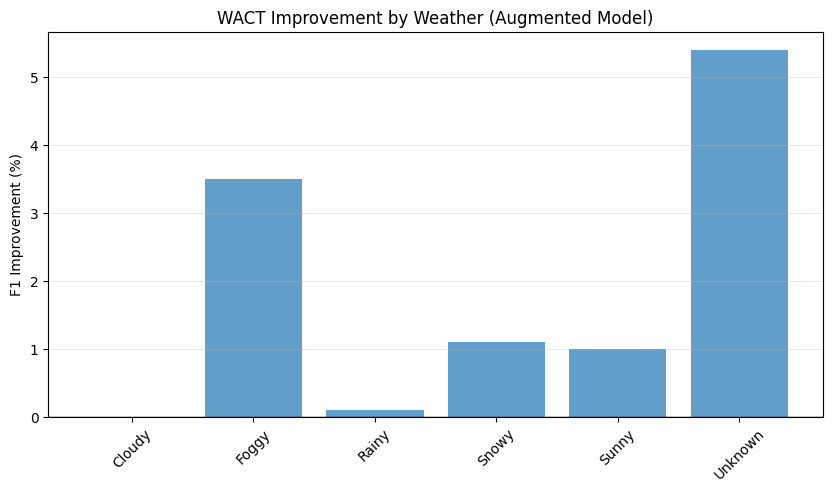


Saved improvement chart: /content/wact_final_improvement.png



In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("APPLYING WACT THRESHOLDS FOR FINAL WEATHER EVALUATION")

try:
    def evaluate_model_at_threshold(model, weather_groups, threshold):
        total_tp, total_fp, total_fn = 0, 0, 0

        for weather, img_list in weather_groups.items():
            for img_name in img_list:
                img_path = val_dir / img_name
                if not img_path.exists():
                    continue

                pred = model.predict(source=str(img_path), conf=threshold, verbose=False)
                det = pred[0].boxes

                # predicted boxes
                if len(det) > 0:
                    pred_boxes = det.xyxy.cpu().numpy().astype(float).tolist()
                else:
                    pred_boxes = []

                # gt boxes
                xml_path = ann_dir / (img_name.replace(".jpg", ".xml"))
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()
                    img_width = int(root.find("size/width").text)
                    img_height = int(root.find("size/height").text)
                    gt_boxes = get_ground_truth_boxes(xml_path, img_width, img_height)
                except:
                    gt_boxes = []

                tp, fp, fn = calculate_metrics_with_iou(pred_boxes, gt_boxes, iou_threshold=0.5)
                total_tp += tp
                total_fp += fp
                total_fn += fn

        # compute precision, recall, F1
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
        recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
        f1 = 2*(precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0

        return round(precision,3), round(recall,3), round(f1,3)

    weather_list = sorted(df_baseline_wact.index)

    results = []

    for weather in weather_list:
        opt_base = float(df_baseline_wact.loc[weather,"optimal_threshold"])
        opt_aug  = float(df_aug_wact.loc[weather,"optimal_threshold"])

        imgs = weather_groups[weather]
        if len(imgs) < 5:
            continue

        # ------ baseline ------
        p_f, r_f, f1_fixed = evaluate_model_at_threshold(baseline_model, {weather: imgs}, threshold=0.25)
        p_w, r_w, f1_wact = evaluate_model_at_threshold(baseline_model, {weather: imgs}, threshold=opt_base)

        # -------augmented -----------
        p_fa, r_fa, f1_fixed_aug = evaluate_model_at_threshold(aug_model, {weather: imgs}, threshold=0.25)
        p_wa, r_wa, f1_wact_aug = evaluate_model_at_threshold(aug_model, {weather: imgs}, threshold=opt_aug)

        results.append([
            weather,
            0.25,
            opt_base,
            f1_fixed,
            f1_wact,
            (f1_wact - f1_fixed) * 100,
            0.25,
            opt_aug,
            f1_fixed_aug,
            f1_wact_aug,
            (f1_wact_aug - f1_fixed_aug) * 100
        ])

    columns = [
        "Weather",
        "Base_Fixed_Thr",
        "Base_WACT_Thr",
        "Base_F1_Fixed",
        "Base_F1_WACT",
        "Base_F1_Improvement(%)",
        "Aug_Fixed_Thr",
        "Aug_WACT_Thr",
        "Aug_F1_Fixed",
        "Aug_F1_WACT",
        "Aug_F1_Improvement(%)"
    ]

    final_df = pd.DataFrame(results, columns=columns).set_index("Weather").round(3)

    print("\n==============================")
    print(" WACT IMPROVEMENT TABLE")
    print("==============================\n")
    print(final_df.to_string())

    plt.figure(figsize=(10,5))
    plt.bar(final_df.index, final_df["Aug_F1_Improvement(%)"], alpha=0.7)
    plt.axhline(0, color="black", linewidth=1)
    plt.xticks(rotation=45)
    plt.ylabel("F1 Improvement (%)")
    plt.title("WACT Improvement by Weather (Augmented Model)")
    plt.grid(axis="y", alpha=0.3)

    plot_path = "/content/wact_final_improvement.png"
    plt.savefig(plot_path, bbox_inches="tight", dpi=150)
    plt.show()

    print(f"\nSaved improvement chart: {plot_path}\n")

except Exception as e:
    print(str(e))


In [22]:
import shutil
from pathlib import Path
import random

print("\nCreating Test Set (20% of Validation)\n")

dataset_root = Path("/content/GERALD_subset")
val_images_dir = dataset_root / "val" / "images"
val_labels_dir = dataset_root / "val" / "labels"

test_images_dir = dataset_root / "test" / "images"
test_labels_dir = dataset_root / "test" / "labels"

# Create directories if missing
test_images_dir.mkdir(parents=True, exist_ok=True)
test_labels_dir.mkdir(parents=True, exist_ok=True)

validation_images = list(val_images_dir.glob("*.jpg"))
random.shuffle(validation_images)

# 20% split
num_test_images = int(0.2 * len(validation_images))
selected_test_images = validation_images[:num_test_images]

moved_images = 0
moved_labels = 0
skipped_files = []

for image_path in selected_test_images:
    try:
        label_path = val_labels_dir / (image_path.stem + ".txt")
        target_image_path = test_images_dir / image_path.name
        shutil.move(str(image_path), str(target_image_path))
        moved_images += 1

        if label_path.exists():
            target_label_path = test_labels_dir / label_path.name
            shutil.move(str(label_path), str(target_label_path))
            moved_labels += 1
        else:
            skipped_files.append(label_path.name)

    except Exception as e:
        print(f"ERROR moving {image_path.name}: {e}")
        skipped_files.append(image_path.name)

print("---Test Split Summary---")
print(f"Total val images:{len(validation_images)}")
print(f"Test images created:{moved_images}")
print(f"Test labels moved:{moved_labels}")
print(f"Missing/Skipped files:{len(skipped_files)}")

if skipped_files:
    print("\nSome files were skipped:")
    for f in skipped_files[:5]:
        print(f" - {f}")
    if len(skipped_files) > 5:
        print(f"... and {len(skipped_files) - 5} more\n")

print("\nTest set created at:")
print(f"  {test_images_dir}")
print(f"  {test_labels_dir}")



Creating Test Set (20% of Validation)

---Test Split Summary---
Total val images:398
Test images created:79
Test labels moved:79
Missing/Skipped files:0

Test set created at:
  /content/GERALD_subset/test/images
  /content/GERALD_subset/test/labels


In [23]:
from ultralytics import YOLO
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd

print("\nApplying WACT thresholds on test set with IoU metrics!!!!\n")

baseline_thr = df_baseline_wact["optimal_threshold"].to_dict()
aug_thr = df_aug_wact["optimal_threshold"].to_dict()

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)

    a1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    a2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = a1 + a2 - inter
    return inter / union if union > 0 else 0.0


def get_gt_boxes(xml_file):
    """Parse GT boxes from PASCAL VOC XML."""
    boxes = []
    try:
        root = ET.parse(xml_file).getroot()
        for obj in root.findall("object"):
            bb = obj.find("bndbox")
            xmin = float(bb.find("xmin").text)
            ymin = float(bb.find("ymin").text)
            xmax = float(bb.find("xmax").text)
            ymax = float(bb.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
    except:
        pass
    return boxes

dataset_root = Path("/content/GERALD_subset")
test_img_dir = dataset_root / "test" / "images"
ann_dir = dataset_root / "annotations"

test_groups = defaultdict(list)

for xml_file in ann_dir.glob("*.xml"):
    root = ET.parse(xml_file).getroot()
    img = root.find("filename").text

    if (test_img_dir / img).exists():
        meta = root.find("metadata")
        weather = meta.find("weather").text if meta is not None else "Unknown"
        test_groups[weather].append(img)
results = []

models = {
    "baseline": "/content/runs/detect/signal_baseline_no_aug/weights/best.pt",
    "augmented": "/content/runs/detect/signal_augmented/weights/best.pt"
}

for weather, img_list in test_groups.items():

    if weather not in baseline_thr:
        continue

    for model_name, model_path in models.items():

        # pick WACT threshold
        conf = baseline_thr[weather] if model_name == "baseline" else aug_thr[weather]
        model = YOLO(model_path)

        total_tp = total_fp = total_fn = 0

        for img_name in img_list:

            img_path = test_img_dir / img_name
            xml_path = ann_dir / img_name.replace(".jpg", ".xml")

            # predictions
            pred = model.predict(source=str(img_path), conf=conf, verbose=False)[0]
            pred_boxes = pred.boxes.xyxy.cpu().numpy().tolist() if len(pred.boxes) > 0 else []

            # ground truth
            gt_boxes = get_gt_boxes(xml_path)

            # match prediction <-> ground truth
            matched_gt = [False] * len(gt_boxes)

            for p in pred_boxes:
                best_iou = 0
                best_gt = -1
                for i, g in enumerate(gt_boxes):
                    if not matched_gt[i]:
                        iou = calculate_iou(p, g)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt = i
                if best_iou >= 0.5:
                    matched_gt[best_gt] = True
                    total_tp += 1
                else:
                    total_fp += 1

            total_fn += matched_gt.count(False)

        # compute metrics
        prec = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
        rec  = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
        f1   = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0

        results.append([
            weather, model_name, conf,
            len(img_list), total_tp, total_fp, total_fn,
            round(prec, 3), round(rec, 3), round(f1, 3)
        ])

df_test = pd.DataFrame(results, columns=[
    "weather", "model", "conf_threshold",
    "samples", "TP", "FP", "FN",
    "precision", "recall", "F1"
])

print("\n---WACT TEST RESULTS (IoU) ---\n")
print(df_test.to_string(index=False))



Applying WACT thresholds on test set with IoU metrics!!!!


---WACT TEST RESULTS (IoU) ---

weather     model  conf_threshold  samples  TP  FP  FN  precision  recall    F1
  Sunny  baseline            0.15       14  10   4  18      0.714   0.357 0.476
  Sunny augmented            0.20       14  13   2  15      0.867   0.464 0.605
  Rainy  baseline            0.25       19  14   4  10      0.778   0.583 0.667
  Rainy augmented            0.30       19  17   2   7      0.895   0.708 0.791
  Foggy  baseline            0.35       11  12   2   3      0.857   0.800 0.828
  Foggy augmented            0.35       11  13   0   2      1.000   0.867 0.929
  Snowy  baseline            0.55        7  12   0   3      1.000   0.800 0.889
  Snowy augmented            0.20        7  14   1   1      0.933   0.933 0.933
 Cloudy  baseline            0.10       17  22   7  13      0.759   0.629 0.688
 Cloudy augmented            0.25       17  25   6  10      0.806   0.714 0.758
Unknown  baseline          

In [24]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!pip install nbconvert


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java 

In [34]:
 #!ls "/content/drive/MyDrive/Colab Notebooks"


'Notebook – GERALD weather aware signal detection – v1 (1).ipynb'
'Notebook – GERALD weather aware signal detection – v1.ipynb'
 WACT_full_report.pdf


In [29]:
!jupyter nbconvert --to pdf --output "WACT_full_report.pdf" "/content/drive/MyDrive/Colab Notebooks/Notebook – GERALD weather aware signal detection – v1.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Notebook – GERALD weather aware signal detection – v1.ipynb to pdf
[NbConvertApp] Support files will be in WACT_full_report_files/
[NbConvertApp] Making directory ./WACT_full_report_files
[NbConvertApp] Writing 292501 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2346729 bytes to /content/drive/MyDrive/Colab Notebooks/WACT_full_report.pdf


In [35]:
from google.colab import files

# Make sure the path is correct
file_path = '/content/drive/MyDrive/Colab Notebooks/WACT_full_report.pdf'

files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp /content/runs/detect/signal_baseline/weights/best.pt /content/drive/MyDrive/



image 1/1 /content/GERALD_subset/images/Rheydt-Aachen.mp4#t=4373.766667.jpg: 384x640 1 distant_signal, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


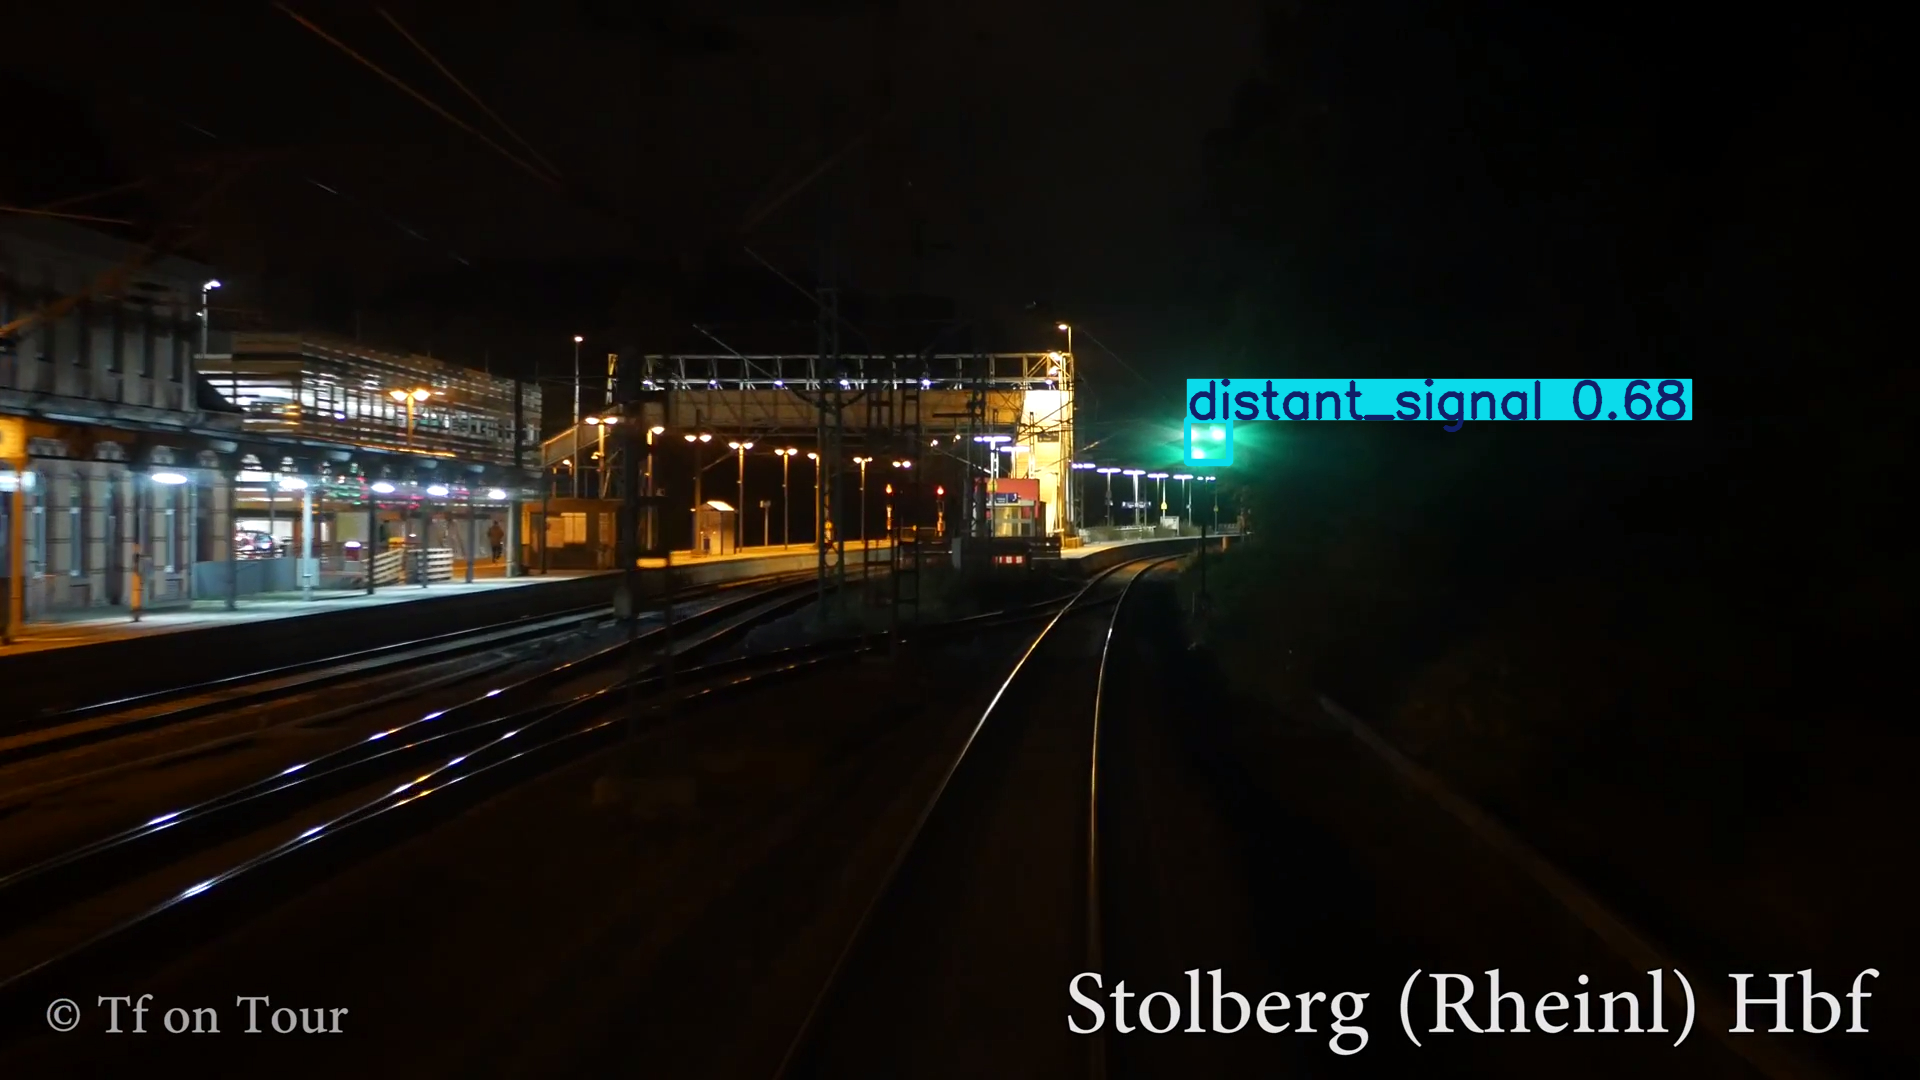

In [ ]:
from ultralytics import YOLO

# load your trained model
model = YOLO("./runs/detect/signal_augmented/weights/best.pt")


# predict on a single image
#results = model("/content/GERALD_subset/images/Fulda-W%C3%BCrzburg.mp4#t=6014.2.jpg")
results = model("/content/GERALD_subset/images/Rheydt-Aachen.mp4#t=4373.766667.jpg")
# show the results for the first (and only) image
results[0].show()  # note the [0]!


In [ ]:
!find . -name "best.pt"




./runs/detect/signal_yolov83/weights/best.pt
